# Load modules and dataset

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install imbalanced-learn
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score, make_scorer, precision_score, recall_score, log_loss
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification, DistilBertTokenizerFast
from transformers import MobileBertTokenizer, TFMobileBertModel
from transformers import AutoTokenizer, TFAlbertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Conv2D,MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, BatchNormalization, Input, Concatenate, Bidirectional
from sklearn.model_selection import StratifiedKFold, cross_validate
import torch
import requests
from tensorflow.keras import activations, optimizers, losses, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras import backend as K

## train data

In [ ]:
path = '/content/drive/MyDrive/FakeNewsChallenge/train.csv'
df = pd.read_csv(path,delimiter=',')

In [ ]:
df.head()

,Headline,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [ ]:
label_encoder = LabelEncoder()
label = df['Stance']
labels_encoded = label_encoder.fit_transform(label)
df['Stance'] = labels_encoded
df.head()

,Headline,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,3,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,0,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",3,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,3,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1,"Fear not arachnophobes, the story of Bunbury's..."


In [ ]:
label_counts = df['Stance'].value_counts()

# Print the label distribution
print(label_counts)

3    36545
2     8909
0     3678
1      840
Name: Stance, dtype: int64


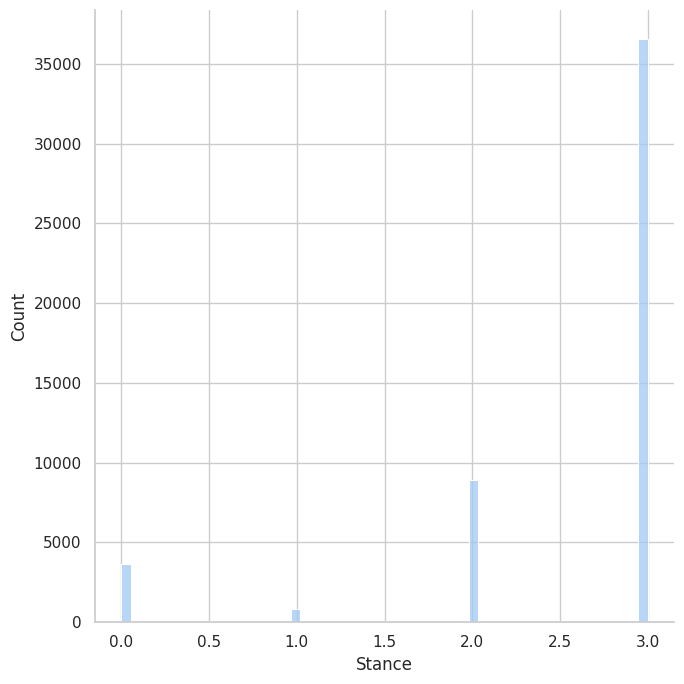

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df, x="Stance",height=7,aspect=1)

## test data

In [ ]:
path = '/content/drive/MyDrive/FakeNewsChallenge/test.csv'
df1 = pd.read_csv(path,delimiter=',')

In [ ]:
df1.head()

,Headline,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,unrelated,A RESPECTED senior French police officer inves...
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,unrelated,Dave Morin's social networking company Path is...
2,A Russian Guy Says His Justin Bieber Ringtone ...,unrelated,A bereaved Afghan mother took revenge on the T...
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",unrelated,Hewlett-Packard is officially splitting in two...
4,Argentina's President Adopts Boy to End Werewo...,unrelated,An airline passenger headed to Dallas was remo...


In [ ]:
label_encoder = LabelEncoder()
label = df1['Stance']
labels_encoded = label_encoder.fit_transform(label)
df1['Stance'] = labels_encoded
df1.head()

,Headline,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,3,A RESPECTED senior French police officer inves...
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,3,Dave Morin's social networking company Path is...
2,A Russian Guy Says His Justin Bieber Ringtone ...,3,A bereaved Afghan mother took revenge on the T...
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",3,Hewlett-Packard is officially splitting in two...
4,Argentina's President Adopts Boy to End Werewo...,3,An airline passenger headed to Dallas was remo...


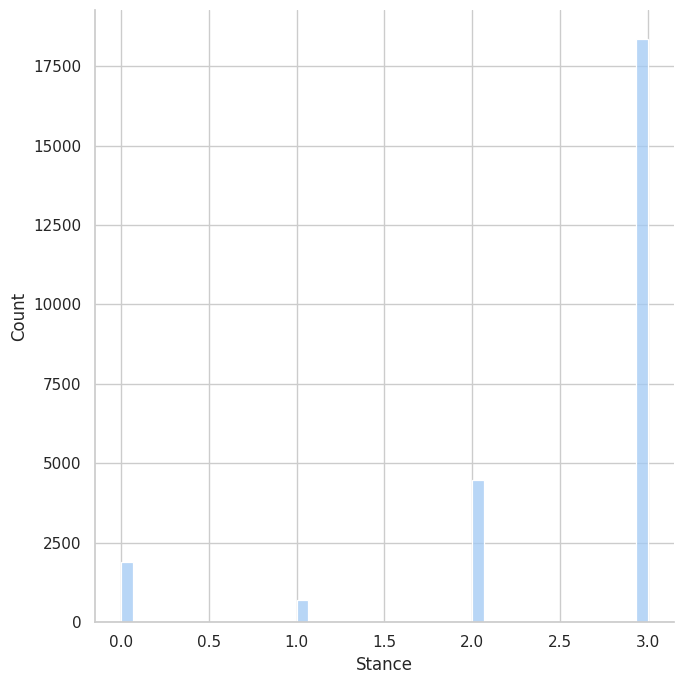

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df1, x="Stance",height=7,aspect=1)

# Fine Tune DistilBERT

In [ ]:
tokenizer_distil = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=4,output_hidden_states=True)

for layer in model_distil.layers[:-3]:
    layer.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
model_distil.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,956,548
Trainable params: 593,668
Non-trainable params: 66,362,880
_________________________________________________________________


In [ ]:
df['Headline'] = df['Headline'].astype(str)
df1['Headline'] = df1['Headline'].astype(str)

In [ ]:
train_encodings = tokenizer_distil(df['Headline'].tolist(), truncation = True, padding = True  )
test_encodings = tokenizer_distil(df1['Headline'].tolist(), truncation = True, padding = True  )

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    df['Stance'].tolist()
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    df1['Stance'].tolist()
))

In [ ]:
train_dataset = train_dataset.batch(32)
test_dataset = test_dataset.batch(32)

In [ ]:
optimizer = optimizers.Adam(learning_rate=(3e-5))
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(train_dataset, batch_size=32, epochs=3)

Epoch 1/3
1562/1562 [==============================] - 181s 104ms/step - loss: 0.7937 - accuracy: 0.7303
Epoch 2/3
1562/1562 [==============================] - 156s 100ms/step - loss: 0.7675 - accuracy: 0.7313
Epoch 3/3
1562/1562 [==============================] - 155s 99ms/step - loss: 0.7603 - accuracy: 0.7313


In [ ]:
benchmarks = model_distil.evaluate(test_dataset, return_dict=True, batch_size=32)

795/795 [==============================] - 526s 659ms/step - loss: 0.8488 - accuracy: 0.7220


In [ ]:
model_distil.save_pretrained('/content/drive/MyDrive/FakeNewsChallenge/distil_text')

# Create Embeddings

In [ ]:
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

## DistilBERT train titles embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['Headline'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 49972/49972 [1:31:43<00:00,  9.08it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_title_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_train_title_distilbert.npy', labels)

## DistilBERT test titles embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df1['Headline'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 25413/25413 [47:13<00:00,  8.97it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df1['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_title_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_test_title_distilbert.npy', labels)

## DistilBERT train text embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['articleBody'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 49972/49972 [1:39:22<00:00,  8.38it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_distilbert.npy', labels)

## DistilBERT test text embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df1['articleBody'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 25413/25413 [51:03<00:00,  8.30it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df1['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_distilbert.npy', labels)

## DistilBERT train maxworth embeddings

In [ ]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests
import json
from tqdm import tqdm
def get_sentence_scores(sentences, api_key):
  api_endpoint = "https://idir.uta.edu/claimbuster/api/v2/score/text/sentences/"
  request_headers = {"x-api-key": api_key}
  payload = {"input_text": sentences}
  api_response = requests.post(url=api_endpoint, json=payload, headers=request_headers)
  return api_response.json()


In [ ]:
def max_worth(text,limit):
  api_key = '*******************************'
  c = get_sentence_scores(text,api_key)
  c = sorted(c['results'], key=lambda x: float(x['score']), reverse=True)
  for res in c:
    res['word_count'] = len(res['text'].split())

  total_words = 0
  last_index = -1

  for i, item in enumerate(c):
    text = item['text']
    word_count = len(text.split())
    if total_words + word_count > 450:
      break
    total_words += word_count
    last_index = i

  c = c[:last_index+1]
  c = sorted(c, key=lambda x: x['index'])
  c = ' '.join([result['text'] for result in c])

  return c

In [ ]:
df['max'] = tqdm(df['articleBody'].apply(max_worth,limit=512))

100%|██████████| 49972/49972 [00:00<00:00, 437572.70it/s]


In [ ]:
df.to_csv('/content/drive/My Drive/FakeNewsChallenge/final_max.csv', index=False)

In [ ]:
path = '/content/drive/MyDrive/FakeNewsChallenge/final_max.csv'
df = pd.read_csv(path,delimiter=',')

In [ ]:
model_distil = TFDistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/FakeNewsChallenge/distil_article',num_labels=4,output_hidden_states=True)

Some layers from the model checkpoint at /content/drive/MyDrive/FakeNewsChallenge/distil_article were not used when initializing TFDistilBertForSequenceClassification: ['dropout_40']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/FakeNewsChallenge/distil_article and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['max'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 49972/49972 [1:34:39<00:00,  8.80it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_max_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_train_max_distilbert.npy', labels)

## DistilBERT test maxworth embeddings

In [ ]:
df1['max'] = tqdm(df1['articleBody'].apply(max_worth,limit=512))

100%|██████████| 25413/25413 [00:00<00:00, 993437.17it/s]


In [ ]:
df1.to_csv('/content/drive/My Drive/FakeNewsChallenge/final_max1.csv', index=False)

In [ ]:
path = '/content/drive/MyDrive/FakeNewsChallenge/final_max1.csv'
df1 = pd.read_csv(path,delimiter=',')

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df1['max'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles =str(titles[i:i+batch_size])

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 25413/25413 [49:18<00:00,  8.59it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df1['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_max_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_test_max_distilbert.npy', labels)

# Text

## **CNN-DistilBERT-Titles**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_distilbert.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_distilbert.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_distilbert.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_distilbert.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
train_labels.shape

(49972,)

In [ ]:
train_labels = to_categorical(train_labels, num_classes=4)
test_labels = to_categorical(test_labels, num_classes=4)

In [ ]:
train_labels.shape

(49972, 4)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 31s 8ms/step - loss: 0.3566 - accuracy: 0.7308
Epoch 2/10
3124/3124 [==============================] - 22s 7ms/step - loss: 0.3358 - accuracy: 0.7308
Epoch 3/10
3124/3124 [==============================] - 18s 6ms/step - loss: 0.3253 - accuracy: 0.7337
Epoch 4/10
3124/3124 [==============================] - 20s 6ms/step - loss: 0.3161 - accuracy: 0.7399
Epoch 5/10
3124/3124 [==============================] - 19s 6ms/step - loss: 0.3069 - accuracy: 0.7504
Epoch 6/10
3124/3124 [==============================] - 18s 6ms/step - loss: 0.2997 - accuracy: 0.7552
Epoch 7/10
3124/3124 [==============================] - 18s 6ms/step - loss: 0.2935 - accuracy: 0.7623
Epoch 8/10
3124/3124 [==============================] - 17s 6ms/step - loss: 0.2914 - accuracy: 0.7639
Epoch 9/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.2859 - accuracy: 0.7679
Epoch 10/10
3124/3124 [==============================] - 17s 6ms/step - l

In [ ]:
a = np.asarray(test_labels).argmax(axis=1)

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 2s 2ms/step
Test Accuracy: 0.6484476327896118
Test F1 Score: 0.2539965044114693
Test Recall: 0.2603478686300699
Precision: 0.26000109880793154


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 128)           0

795/795 [==============================] - 2s 2ms/step
[[    0     0     0  1903]
 [    0     0     0   697]
 [    0     0     0  4464]
 [    0     0     0 18349]]


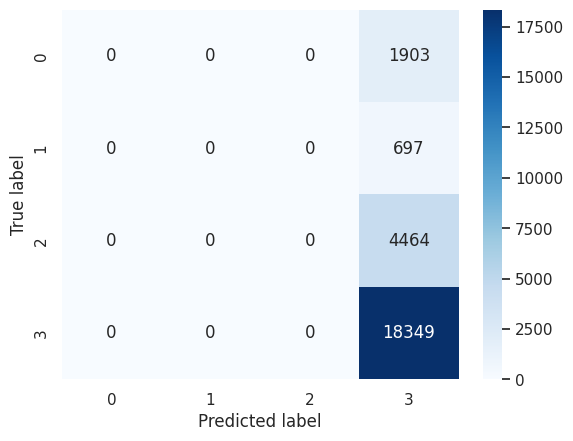

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    # Print the classification report
    print(classification_report(a, y_pred))

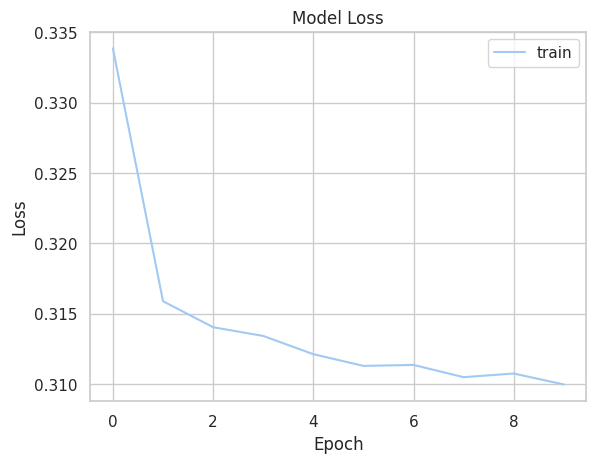

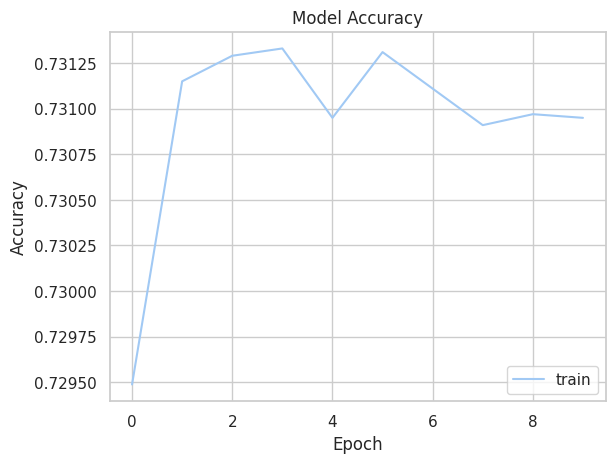

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1903
           1       0.00      0.00      0.00       697
           2       0.00      0.00      0.00      4464
           3       0.72      1.00      0.84     18349

    accuracy                           0.72     25413
   macro avg       0.18      0.25      0.21     25413
weighted avg       0.52      0.72      0.61     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_history(history1,model)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
2499/2499 [==============================] - 20s 7ms/step - loss: 0.3383 - accuracy: 0.7286
Epoch 2/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.3178 - accuracy: 0.7310
Epoch 3/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.3148 - accuracy: 0.7310
Epoch 4/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.3137 - accuracy: 0.7313
Epoch 5/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.3132 - accuracy: 0.7313
Epoch 6/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.3129 - accuracy: 0.7312
Epoch 7/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.3110 - accuracy: 0.7310
Epoch 8/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.3116 - accuracy: 0.7312
Epoch 9/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.3111 - accuracy: 0.7310
Epoch 10/10
313/313 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 4ms/step - loss: 0.3048 - accuracy: 0.7313
Epoch 1/10
2499/2499 [==============================] - 19s 7ms/step - loss: 0.3420 - accuracy: 0.7291
Epoch 2/10
2499/2499 [==============================] - 16s 7ms/step - loss: 0.3179 - accuracy: 0.7312
Epoch 3/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.3150 - accuracy: 0.7311
Epoch 4/10
2499/2499 [==============================] - 16s 7ms/step - loss: 0.3125 - accuracy: 0.7313
Epoch 5/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3120 - accuracy: 0.7311
Epoch 6/10
2499/2499 [==============================] - 16s 7ms/step - loss: 0.3118 - accuracy: 0.7312
Epoch 7/10
2499/2499 [==============================] - 16s 7ms/step - loss: 0.3111 - accuracy: 0.7312
Epoch 8/10
2499/2499 [==============================] - 16s 7ms/step - loss: 0.3100 - accuracy: 0.7312
Epoch 9/10
2499/2499 [==============================] - 16s 7ms/step - loss: 0.3097 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 2s 5ms/step - loss: 0.3097 - accuracy: 0.7313
Epoch 1/10
2499/2499 [==============================] - 20s 7ms/step - loss: 0.3384 - accuracy: 0.7295
Epoch 2/10
2499/2499 [==============================] - 16s 7ms/step - loss: 0.3168 - accuracy: 0.7312
Epoch 3/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.3145 - accuracy: 0.7313
Epoch 4/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3134 - accuracy: 0.7313
Epoch 5/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3128 - accuracy: 0.7313
Epoch 6/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3117 - accuracy: 0.7310
Epoch 7/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3114 - accuracy: 0.7311
Epoch 8/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3117 - accuracy: 0.7313
Epoch 9/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3109 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.3060 - accuracy: 0.7313
Epoch 1/10
2499/2499 [==============================] - 18s 6ms/step - loss: 0.3403 - accuracy: 0.7299
Epoch 2/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3182 - accuracy: 0.7314
Epoch 3/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3149 - accuracy: 0.7313
Epoch 4/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3134 - accuracy: 0.7310
Epoch 5/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3132 - accuracy: 0.7313
Epoch 6/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3129 - accuracy: 0.7312
Epoch 7/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3125 - accuracy: 0.7311
Epoch 8/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3117 - accuracy: 0.7311
Epoch 9/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3116 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.3064 - accuracy: 0.7313
Epoch 1/10
2499/2499 [==============================] - 18s 6ms/step - loss: 0.3423 - accuracy: 0.7298
Epoch 2/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3185 - accuracy: 0.7312
Epoch 3/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3148 - accuracy: 0.7313
Epoch 4/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3132 - accuracy: 0.7312
Epoch 5/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3127 - accuracy: 0.7310
Epoch 6/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3124 - accuracy: 0.7308
Epoch 7/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3120 - accuracy: 0.7308
Epoch 8/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3115 - accuracy: 0.7308
Epoch 9/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3109 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.3084 - accuracy: 0.7313


In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7313095350957447
Precision: 0.5348136374068945
Loss: 0.3070503056049347
Recall: 0.7313095350957447
F1-score: 0.6178140023020922


## **LSTM-DistilBERT-Titles**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(64, return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Flatten())
model2.add(Dense(4, activation='softmax'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
3124/3124 [==============================] - 107s 30ms/step - loss: 0.3115 - accuracy: 0.7290 - val_loss: 0.3741 - val_accuracy: 0.7220
Epoch 2/10
3124/3124 [==============================] - 52s 17ms/step - loss: 0.3069 - accuracy: 0.7305 - val_loss: 0.3827 - val_accuracy: 0.7220
Epoch 3/10
3124/3124 [==============================] - 50s 16ms/step - loss: 0.3063 - accuracy: 0.7311 - val_loss: 0.3721 - val_accuracy: 0.7220
Epoch 4/10
3124/3124 [==============================] - 53s 17ms/step - loss: 0.3056 - accuracy: 0.7311 - val_loss: 0.3717 - val_accuracy: 0.7220
Epoch 5/10
3124/3124 [==============================] - 51s 16ms/step - loss: 0.3054 - accuracy: 0.7311 - val_loss: 0.3688 - val_accuracy: 0.7220
Epoch 6/10
3124/3124 [==============================] - 53s 17ms/step - loss: 0.3050 - accuracy: 0.7312 - val_loss: 0.3774 - val_accuracy: 0.7220
Epoch 7/10
3124/3124 [==============================] - 51s 16ms/step - loss: 0.3050 - accuracy: 0.7310 - val_loss: 0.3648 

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels)

y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 6s 7ms/step
Test Accuracy: 0.7220320105552673
Test F1 Score: 0.2096453544170742
Test Recall: 0.25
Precision: 0.18050800771258804


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 189, 64)           49408     
                                                                 
 batch_normalization_1 (Batc  (None, 189, 64)         

795/795 [==============================] - 6s 8ms/step
[[    0     0     0  1903]
 [    0     0     0   697]
 [    0     0     0  4464]
 [    0     0     0 18349]]


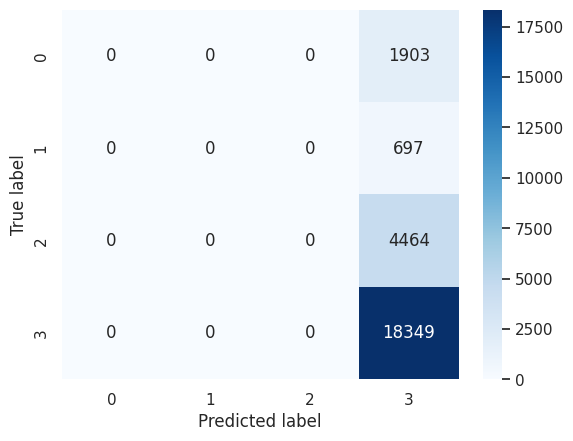

In [ ]:
y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

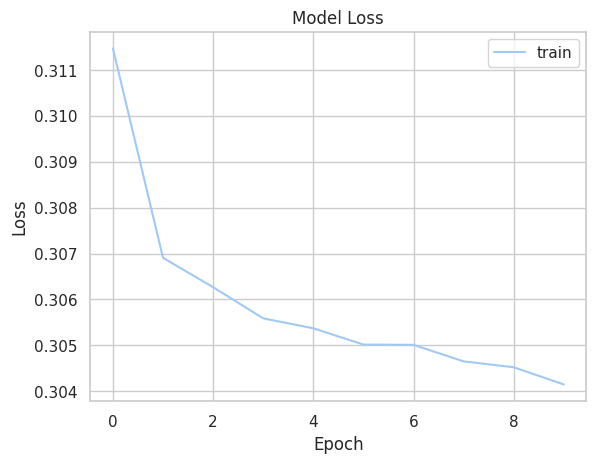

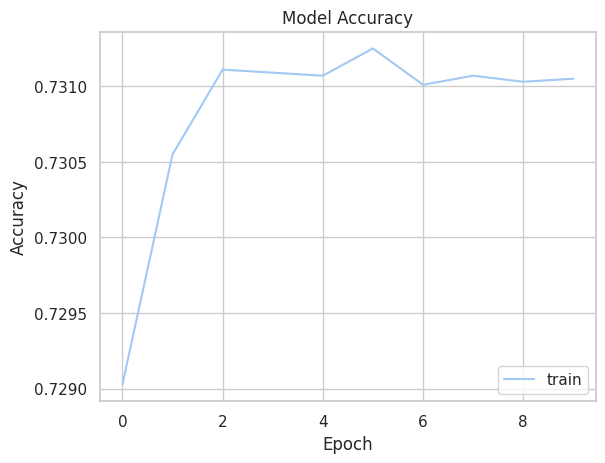

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1903
           1       0.00      0.00      0.00       697
           2       0.00      0.00      0.00      4464
           3       0.72      1.00      0.84     18349

    accuracy                           0.72     25413
   macro avg       0.18      0.25      0.21     25413
weighted avg       0.52      0.72      0.61     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_history(history2,model2)

In [ ]:
def create_model():
  model2 = Sequential()
  model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(Conv1D(128, 5, activation='relu'))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(LSTM(64, return_sequences=True))
  model2.add(BatchNormalization())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dense(64, activation='relu'))
  model2.add(Dense(32, activation='relu'))
  model2.add(Flatten())
  model2.add(Dense(4, activation='softmax'))
  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model2


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
2499/2499 [==============================] - 48s 13ms/step - loss: 0.3324 - accuracy: 0.7321
Epoch 2/10
2499/2499 [==============================] - 44s 17ms/step - loss: 0.3100 - accuracy: 0.7381
Epoch 3/10
2499/2499 [==============================] - 31s 13ms/step - loss: 0.2928 - accuracy: 0.7532
Epoch 4/10
2499/2499 [==============================] - 33s 13ms/step - loss: 0.2800 - accuracy: 0.7656
Epoch 5/10
2499/2499 [==============================] - 32s 13ms/step - loss: 0.2705 - accuracy: 0.7761
Epoch 6/10
2499/2499 [==============================] - 32s 13ms/step - loss: 0.2642 - accuracy: 0.7827
Epoch 7/10
2499/2499 [==============================] - 32s 13ms/step - loss: 0.2611 - accuracy: 0.7878
Epoch 8/10
2499/2499 [==============================] - 32s 13ms/step - loss: 0.2579 - accuracy: 0.7894
Epoch 9/10
2499/2499 [==============================] - 33s 13ms/step - loss: 0.2552 - accuracy: 0.7915
Epoch 10/10
313/313 [==============================] - 3s 7ms/st

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7716721818984338
Precision: 0.7377885069210783
Loss: 0.2807031571865082
Recall: 0.7716721818984338
F1-score: 0.7382248783152653


## **FakeBert-DistilBERT-Titles**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(4, activation='softmax')(dropout2)
model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
3124/3124 [==============================] - 46s 14ms/step - loss: 0.3466 - accuracy: 0.7305 - val_loss: 0.3757 - val_accuracy: 0.7220
Epoch 2/10
3124/3124 [==============================] - 42s 14ms/step - loss: 0.3180 - accuracy: 0.7346 - val_loss: 0.3773 - val_accuracy: 0.7149
Epoch 3/10
3124/3124 [==============================] - 39s 12ms/step - loss: 0.2971 - accuracy: 0.7523 - val_loss: 0.3861 - val_accuracy: 0.6960
Epoch 4/10
3124/3124 [==============================] - 43s 14ms/step - loss: 0.2821 - accuracy: 0.7659 - val_loss: 0.4103 - val_accuracy: 0.6823
Epoch 5/10
3124/3124 [==============================] - 43s 14ms/step - loss: 0.2708 - accuracy: 0.7784 - val_loss: 0.3933 - val_accuracy: 0.6734
Epoch 6/10
3124/3124 [==============================] - 43s 14ms/step - loss: 0.2648 - accuracy: 0.7847 - val_loss: 0.4090 - val_accuracy: 0.6658
Epoch 7/10
3124/3124 [==============================] - 40s 13ms/step - loss: 0.2594 - accuracy: 0.7892 - val_loss: 0.4116 -

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels)

y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 4s 5ms/step
Test Accuracy: 0.5838350653648376
Test F1 Score: 0.2648510456304642
Test Recall: 0.2670412119675897
Precision: 0.2800184003497588


In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 768, 128)     512         ['input_1[0][0]']                
                                                                                                  
 conv1d_11 (Conv1D)             (None, 768, 128)     640         ['input_1[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 768, 128)     768         ['input_1[0][0]']                
                                                                                              

795/795 [==============================] - 4s 5ms/step
[[  264     2   151  1486]
 [  126     5    42   524]
 [  185     8   757  3514]
 [ 1468    43  3027 13811]]


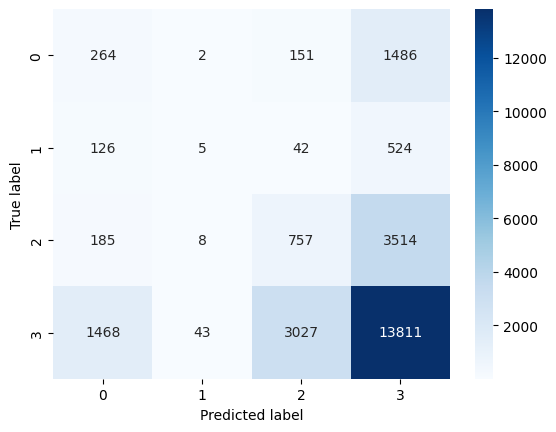

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  inputs = Input(shape=(768, 1))
  conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
  maxpool1 = MaxPooling1D(pool_size=2)(conv1)
  conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
  maxpool2 = MaxPooling1D(pool_size=2)(conv2)
  conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
  maxpool3 = MaxPooling1D(pool_size=2)(conv3)
  concat = Concatenate()([maxpool1, maxpool2, maxpool3])
  conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
  maxpool4 = MaxPooling1D(pool_size=2)(conv4)
  flatten = Flatten()(maxpool4)
  dense1 = Dense(384, activation='relu')(flatten)
  dropout1 = Dropout(0.5)(dense1)
  dense2 = Dense(128, activation='relu')(dropout1)
  dropout2 = Dropout(0.5)(dense2)
  output = Dense(4, activation='softmax')(dropout2)
  model3 = Model(inputs=inputs, outputs=output)
  model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model3

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)


Epoch 1/10
2499/2499 [==============================] - 37s 14ms/step - loss: 0.3483 - accuracy: 0.7301
Epoch 2/10
2499/2499 [==============================] - 25s 10ms/step - loss: 0.3223 - accuracy: 0.7329
Epoch 3/10
2499/2499 [==============================] - 27s 11ms/step - loss: 0.3030 - accuracy: 0.7445
Epoch 4/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2888 - accuracy: 0.7600
Epoch 5/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2750 - accuracy: 0.7737
Epoch 6/10
2499/2499 [==============================] - 26s 11ms/step - loss: 0.2683 - accuracy: 0.7820
Epoch 7/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2627 - accuracy: 0.7874
Epoch 8/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2578 - accuracy: 0.7902
Epoch 9/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2563 - accuracy: 0.7918
Epoch 10/10
313/313 [==============================] - 2s 7ms/st

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 2s 6ms/step - loss: 0.2523 - accuracy: 0.7965
Epoch 1/10
2499/2499 [==============================] - 29s 10ms/step - loss: 0.3495 - accuracy: 0.7303
Epoch 2/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.3210 - accuracy: 0.7344
Epoch 3/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.3021 - accuracy: 0.7484
Epoch 4/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2868 - accuracy: 0.7603
Epoch 5/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2751 - accuracy: 0.7714
Epoch 6/10
2499/2499 [==============================] - 25s 10ms/step - loss: 0.2674 - accuracy: 0.7799
Epoch 7/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2609 - accuracy: 0.7873
Epoch 8/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2567 - accuracy: 0.7920
Epoch 9/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7975466780818866
Precision: 0.7745583146566767
Loss: 0.24969875812530518
Recall: 0.7975466780818866
F1-score: 0.7615613225279186


## **CNN Light - DistilBERT**

In [ ]:
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
model4.add(MaxPooling1D(pool_size = 2))
model4.add(Flatten())
model4.add(Dense(units=64, activation='relu'))
model4.add(Dense(units=4, activation='softmax'))

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_embeddings, train_labels, epochs=10, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.3295 - accuracy: 0.7328 - val_loss: 0.3768 - val_accuracy: 0.7222
Epoch 2/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.3099 - accuracy: 0.7381 - val_loss: 0.3817 - val_accuracy: 0.6856
Epoch 3/10
3124/3124 [==============================] - 16s 5ms/step - loss: 0.2964 - accuracy: 0.7474 - val_loss: 0.3916 - val_accuracy: 0.6579
Epoch 4/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.2849 - accuracy: 0.7591 - val_loss: 0.4013 - val_accuracy: 0.6726
Epoch 5/10
3124/3124 [==============================] - 15s 5ms/step - loss: 0.2758 - accuracy: 0.7696 - val_loss: 0.4176 - val_accuracy: 0.6821
Epoch 6/10
3124/3124 [==============================] - 15s 5ms/step - loss: 0.2688 - accuracy: 0.7771 - val_loss: 0.4289 - val_accuracy: 0.6595
Epoch 7/10
3124/3124 [==============================] - 15s 5ms/step - loss: 0.2641 - accuracy: 0.7819 - val_loss: 0.4418 - val_ac

In [ ]:
test_loss, test_acc = model4.evaluate(test_embeddings, test_labels)

y_pred = model4.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 1s 2ms/step
Test Accuracy: 0.6740251183509827
Test F1 Score: 0.22847559070019638
Test Recall: 0.24765494766625346
Precision: 0.23021710848537036


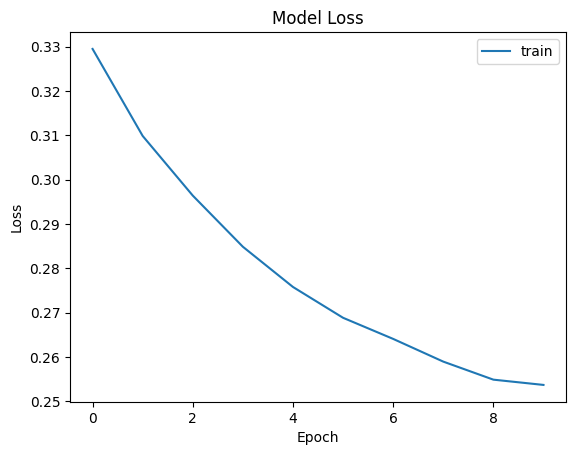

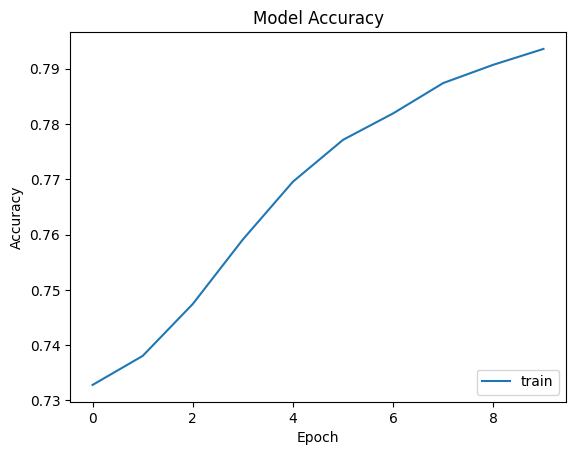

              precision    recall  f1-score   support

           0       0.02      0.00      0.00      1903
           1       0.00      0.00      0.00       697
           2       0.18      0.07      0.10      4464
           3       0.72      0.92      0.81     18349

    accuracy                           0.67     25413
   macro avg       0.23      0.25      0.23     25413
weighted avg       0.55      0.67      0.60     25413



In [ ]:
plot_history(history4,model4)

In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_55 (Conv1D)          (None, 766, 32)           128       
                                                                 
 max_pooling1d_55 (MaxPoolin  (None, 383, 32)          0         
 g1D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 12256)             0         
                                                                 
 dense_55 (Dense)            (None, 64)                784448    
                                                                 
 dense_56 (Dense)            (None, 4)                 260       
                                                                 
Total params: 784,836
Trainable params: 784,836
Non-trainable params: 0
________________________________________________

795/795 [==============================] - 1s 2ms/step
[[    5     0    87  1811]
 [    9     0    29   659]
 [   34     7   323  4100]
 [  234     0  1314 16801]]


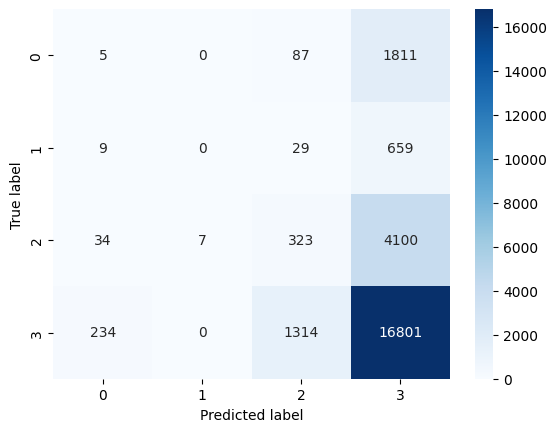

In [ ]:
y_pred = model4.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  model4 = Sequential()
  model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
  model4.add(MaxPooling1D(pool_size = 2))
  model4.add(Flatten())
  model4.add(Dense(units=64, activation='relu'))
  model4.add(Dense(units=4, activation='softmax'))
  model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model4


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
2499/2499 [==============================] - 12s 4ms/step - loss: 0.3310 - accuracy: 0.7316
Epoch 2/10
2499/2499 [==============================] - 9s 4ms/step - loss: 0.3138 - accuracy: 0.7361
Epoch 3/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.3006 - accuracy: 0.7434
Epoch 4/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.2906 - accuracy: 0.7525
Epoch 5/10
2499/2499 [==============================] - 9s 4ms/step - loss: 0.2828 - accuracy: 0.7595
Epoch 6/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.2757 - accuracy: 0.7656
Epoch 7/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.2706 - accuracy: 0.7727
Epoch 8/10
2499/2499 [==============================] - 9s 4ms/step - loss: 0.2661 - accuracy: 0.7785
Epoch 9/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.2624 - accuracy: 0.7822
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.2724 - accuracy: 0.7811
Epoch 1/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.3326 - accuracy: 0.7308
Epoch 2/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.3163 - accuracy: 0.7336
Epoch 3/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.3063 - accuracy: 0.7395
Epoch 4/10
2499/2499 [==============================] - 9s 4ms/step - loss: 0.2965 - accuracy: 0.7471
Epoch 5/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.2891 - accuracy: 0.7541
Epoch 6/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.2830 - accuracy: 0.7602
Epoch 7/10
2499/2499 [==============================] - 9s 3ms/step - loss: 0.2772 - accuracy: 0.7678
Epoch 8/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.2725 - accuracy: 0.7718
Epoch 9/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.2693 - acc

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.782638117137416
Precision: 0.7563916582450018
Loss: 0.2699078381061554
Recall: 0.782638117137416
F1-score: 0.7461964272457638


## **Bidirectional L2 LSTM-DistilBERT**

In [ ]:
model5 = Sequential()
model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(128, 5, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Bidirectional(LSTM(64, return_sequences=True)))
model5.add(BatchNormalization())
model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Flatten())
model5.add(Dense(4, activation='softmax'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 62s 18ms/step - loss: 0.3930 - accuracy: 0.7313
Epoch 2/10
3124/3124 [==============================] - 55s 18ms/step - loss: 0.3252 - accuracy: 0.7348
Epoch 3/10
3124/3124 [==============================] - 55s 18ms/step - loss: 0.3145 - accuracy: 0.7411
Epoch 4/10
3124/3124 [==============================] - 55s 18ms/step - loss: 0.3030 - accuracy: 0.7506
Epoch 5/10
3124/3124 [==============================] - 56s 18ms/step - loss: 0.2937 - accuracy: 0.7587
Epoch 6/10
3124/3124 [==============================] - 56s 18ms/step - loss: 0.2857 - accuracy: 0.7690
Epoch 7/10
3124/3124 [==============================] - 55s 18ms/step - loss: 0.2792 - accuracy: 0.7737
Epoch 8/10
3124/3124 [==============================] - 55s 18ms/step - loss: 0.2732 - accuracy: 0.7798
Epoch 9/10
3124/3124 [==============================] - 55s 18ms/step - loss: 0.2676 - accuracy: 0.7855
Epoch 10/10
3124/3124 [==============================] - 55s 18m

In [ ]:
test_loss, test_acc = model5.evaluate(test_embeddings, test_labels)

y_pred = model5.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 9s 10ms/step
Test Accuracy: 0.6820131540298462
Test F1 Score: 0.24723100650652538
Test Recall: 0.26046480621829904
Precision: 0.26164434946737675


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


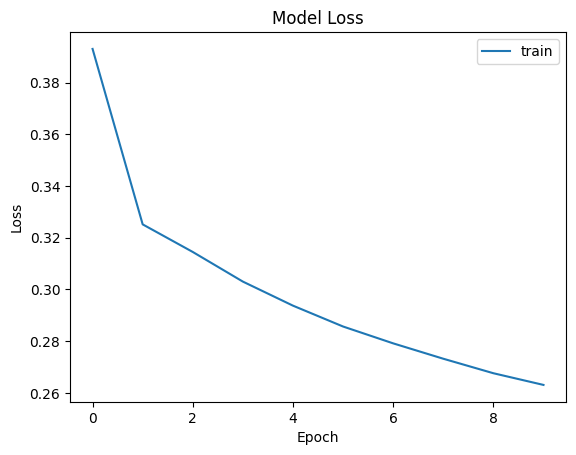

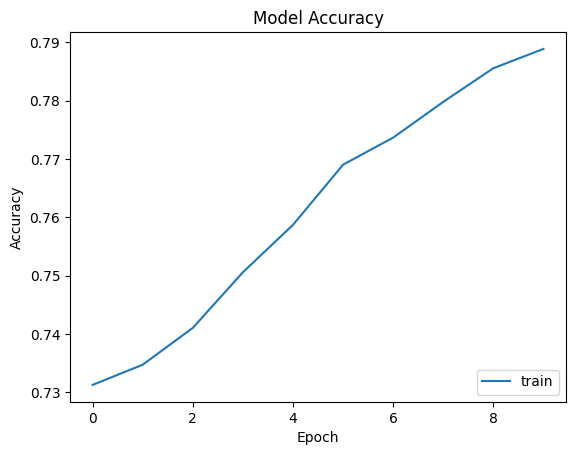

              precision    recall  f1-score   support

           0       0.04      0.01      0.01      1903
           1       0.00      0.00      0.00       697
           2       0.28      0.12      0.17      4464
           3       0.72      0.91      0.81     18349

    accuracy                           0.68     25413
   macro avg       0.26      0.26      0.25     25413
weighted avg       0.58      0.68      0.61     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_history(history5,model5)

In [ ]:
model5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_61 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_61 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_62 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_62 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirectiona  (None, 189, 128)         98816     
 l)                                                              
                                                     

795/795 [==============================] - 8s 9ms/step
[[   14     0    62  1827]
 [    1     0    26   670]
 [   39     0   535  3890]
 [  283     0  1283 16783]]


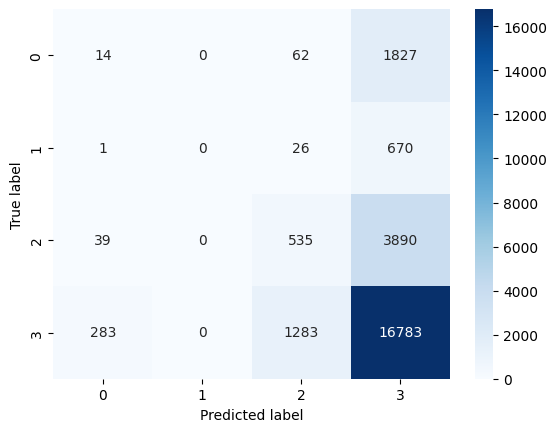

In [ ]:
y_pred = model5.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  model5 = Sequential()
  model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Conv1D(128, 5, activation='relu'))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Bidirectional(LSTM(64, return_sequences=True)))
  model5.add(BatchNormalization())
  model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Flatten())
  model5.add(Dense(4, activation='softmax'))
  model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model5


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
2499/2499 [==============================] - 50s 18ms/step - loss: 0.4110 - accuracy: 0.7306
Epoch 2/10
2499/2499 [==============================] - 44s 18ms/step - loss: 0.3304 - accuracy: 0.7320
Epoch 3/10
2499/2499 [==============================] - 44s 18ms/step - loss: 0.3199 - accuracy: 0.7376
Epoch 4/10
2499/2499 [==============================] - 46s 18ms/step - loss: 0.3105 - accuracy: 0.7429
Epoch 5/10
2499/2499 [==============================] - 44s 18ms/step - loss: 0.3022 - accuracy: 0.7513
Epoch 6/10
2499/2499 [==============================] - 44s 18ms/step - loss: 0.2949 - accuracy: 0.7568
Epoch 7/10
2499/2499 [==============================] - 46s 18ms/step - loss: 0.2885 - accuracy: 0.7629
Epoch 8/10
2499/2499 [==============================] - 44s 18ms/step - loss: 0.2832 - accuracy: 0.7701
Epoch 9/10
2499/2499 [==============================] - 45s 18ms/step - loss: 0.2777 - accuracy: 0.7734
Epoch 10/10
313/313 [==============================] - 4s 11ms/s

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7681499905446019
Precision: 0.7462222900633767
Loss: 0.283209627866745
Recall: 0.7681499905446019
F1-score: 0.7376191760738126


## **L2 CNN-DistilBERT**

In [ ]:
# build the model
model6 = Sequential()
model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Flatten())
model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(4, activation='softmax'))

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 34s 10ms/step - loss: 0.4066 - accuracy: 0.7305
Epoch 2/10
3124/3124 [==============================] - 30s 10ms/step - loss: 0.3463 - accuracy: 0.7313
Epoch 3/10
3124/3124 [==============================] - 24s 8ms/step - loss: 0.3411 - accuracy: 0.7308
Epoch 4/10
3124/3124 [==============================] - 25s 8ms/step - loss: 0.3347 - accuracy: 0.7313
Epoch 5/10
3124/3124 [==============================] - 22s 7ms/step - loss: 0.3297 - accuracy: 0.7315
Epoch 6/10
3124/3124 [==============================] - 18s 6ms/step - loss: 0.3242 - accuracy: 0.7341
Epoch 7/10
3124/3124 [==============================] - 18s 6ms/step - loss: 0.3189 - accuracy: 0.7391
Epoch 8/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.3162 - accuracy: 0.7389
Epoch 9/10
3124/3124 [==============================] - 17s 6ms/step - loss: 0.3125 - accuracy: 0.7469
Epoch 10/10
3124/3124 [==============================] - 17s 5ms/step -

In [ ]:
test_loss, test_acc = model6.evaluate(test_embeddings, test_labels)

y_pred = model6.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 2s 2ms/step
Test Accuracy: 0.6348719000816345
Test F1 Score: 0.23477864321611439
Test Recall: 0.24889314405031399
Precision: 0.22355059298737093


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


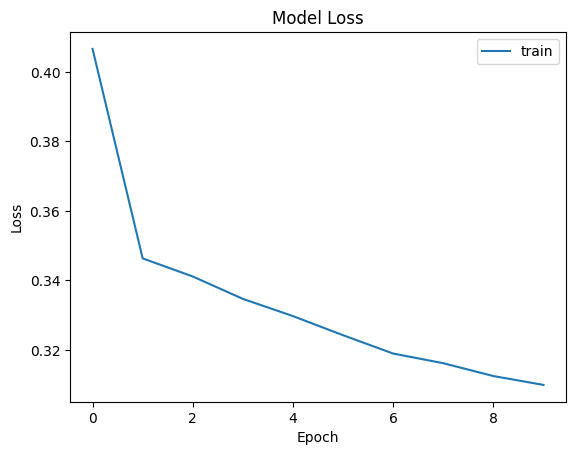

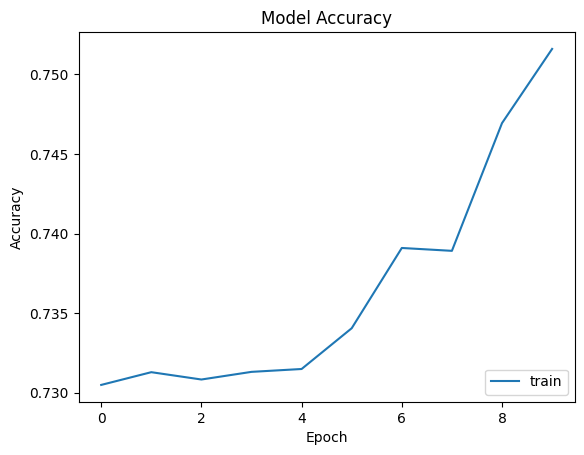

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1903
           1       0.00      0.00      0.00       697
           2       0.18      0.15      0.16      4464
           3       0.72      0.84      0.77     18349

    accuracy                           0.63     25413
   macro avg       0.22      0.25      0.23     25413
weighted avg       0.55      0.63      0.59     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_history(history6,model6)

In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model6.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_73 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_73 (MaxPoolin  (None, 152, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_74 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_74 (MaxPoolin  (None, 29, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_75 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 max_pooling1d_75 (MaxPoolin  (None, 5, 128)         

795/795 [==============================] - 2s 2ms/step
[[    0     0   235  1668]
 [    0     0    59   638]
 [    0     0   686  3778]
 [    0     0  2901 15448]]


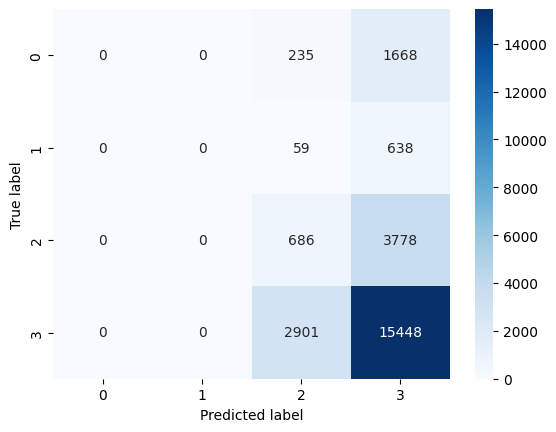

In [ ]:
y_pred = model6.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  model6 = Sequential()
  model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Flatten())
  model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(4, activation='softmax'))
  model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model6


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.4224 - accuracy: 0.7299
Epoch 2/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3499 - accuracy: 0.7313
Epoch 3/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3448 - accuracy: 0.7312
Epoch 4/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3408 - accuracy: 0.7311
Epoch 5/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3372 - accuracy: 0.7310
Epoch 6/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3336 - accuracy: 0.7307
Epoch 7/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3302 - accuracy: 0.7316
Epoch 8/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3273 - accuracy: 0.7320
Epoch 9/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3242 - accuracy: 0.7336
Epoch 10/10
313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.3144 - accuracy: 0.7374
Epoch 1/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.4212 - accuracy: 0.7287
Epoch 2/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3498 - accuracy: 0.7313
Epoch 3/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3450 - accuracy: 0.7312
Epoch 4/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3407 - accuracy: 0.7312
Epoch 5/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3377 - accuracy: 0.7317
Epoch 6/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3343 - accuracy: 0.7313
Epoch 7/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3301 - accuracy: 0.7312
Epoch 8/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3271 - accuracy: 0.7327
Epoch 9/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3241 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.3182 - accuracy: 0.7373
Epoch 1/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.4232 - accuracy: 0.7290
Epoch 2/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3494 - accuracy: 0.7313
Epoch 3/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3455 - accuracy: 0.7313
Epoch 4/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.3412 - accuracy: 0.7316
Epoch 5/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3373 - accuracy: 0.7314
Epoch 6/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3335 - accuracy: 0.7306
Epoch 7/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3299 - accuracy: 0.7308
Epoch 8/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.3261 - accuracy: 0.7322
Epoch 9/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3229 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.3156 - accuracy: 0.7439
Epoch 1/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.4216 - accuracy: 0.7306
Epoch 2/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.3485 - accuracy: 0.7313
Epoch 3/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3441 - accuracy: 0.7311
Epoch 4/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3397 - accuracy: 0.7310
Epoch 5/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3362 - accuracy: 0.7320
Epoch 6/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.3315 - accuracy: 0.7329
Epoch 7/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.3288 - accuracy: 0.7339
Epoch 8/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3245 - accuracy: 0.7366
Epoch 9/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3215 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.3100 - accuracy: 0.7574
Epoch 1/10
2499/2499 [==============================] - 17s 5ms/step - loss: 0.4201 - accuracy: 0.7296
Epoch 2/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3485 - accuracy: 0.7313
Epoch 3/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.3438 - accuracy: 0.7310
Epoch 4/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.3406 - accuracy: 0.7313
Epoch 5/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.3366 - accuracy: 0.7310
Epoch 6/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.3333 - accuracy: 0.7306
Epoch 7/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.3293 - accuracy: 0.7322
Epoch 8/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.3259 - accuracy: 0.7338
Epoch 9/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3229 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 4ms/step - loss: 0.3169 - accuracy: 0.7351


In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7422158367556801
Precision: 0.6580849946252184
Loss: 0.3150362491607666
Recall: 0.7422158367556801
F1-score: 0.6562273086984887


# Max - Worth

## **CNN-DistilBERT-Titles**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_max_distilbert.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_max_distilbert.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_max_distilbert.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_max_distilbert.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
train_labels.shape

(49972,)

In [ ]:
train_labels = to_categorical(train_labels, num_classes=4)
test_labels = to_categorical(test_labels, num_classes=4)

In [ ]:
train_labels.shape

(49972, 4)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 26s 7ms/step - loss: 0.3594 - accuracy: 0.7288
Epoch 2/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.3331 - accuracy: 0.7320
Epoch 3/10
3124/3124 [==============================] - 18s 6ms/step - loss: 0.3178 - accuracy: 0.7368
Epoch 4/10
3124/3124 [==============================] - 17s 6ms/step - loss: 0.3048 - accuracy: 0.7476
Epoch 5/10
3124/3124 [==============================] - 17s 6ms/step - loss: 0.2958 - accuracy: 0.7574
Epoch 6/10
3124/3124 [==============================] - 18s 6ms/step - loss: 0.2873 - accuracy: 0.7642
Epoch 7/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.2813 - accuracy: 0.7694
Epoch 8/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.2774 - accuracy: 0.7754
Epoch 9/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.2721 - accuracy: 0.7794
Epoch 10/10
3124/3124 [==============================] - 17s 6ms/step - l

In [ ]:
a = np.asarray(test_labels).argmax(axis=1)

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 2s 2ms/step
Test Accuracy: 0.6628103852272034
Test F1 Score: 0.24689394102678536
Test Recall: 0.25661951435908753
Precision: 0.26455550951841045


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_94 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_94 (MaxPoolin  (None, 152, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_95 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_95 (MaxPoolin  (None, 29, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_96 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 max_pooling1d_96 (MaxPoolin  (None, 5, 128)         

795/795 [==============================] - 2s 2ms/step
[[   81     0    74  1748]
 [   28     0    21   648]
 [   36     0   415  4013]
 [  433     0  1568 16348]]


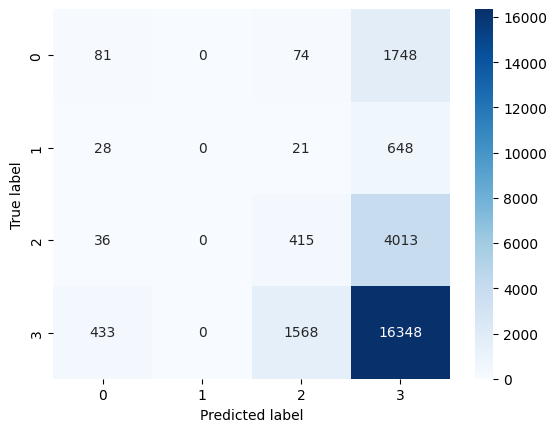

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    # Print the classification report
    print(classification_report(a, y_pred))

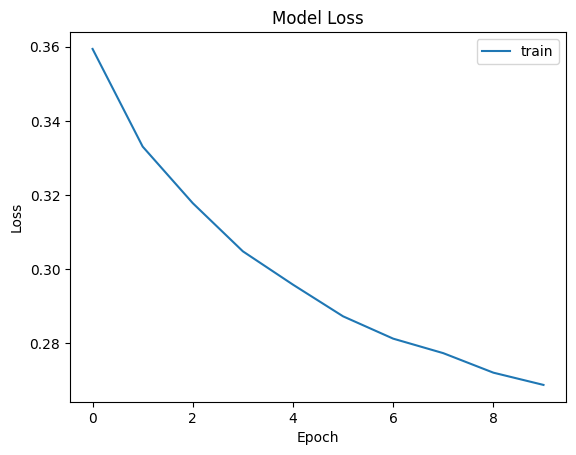

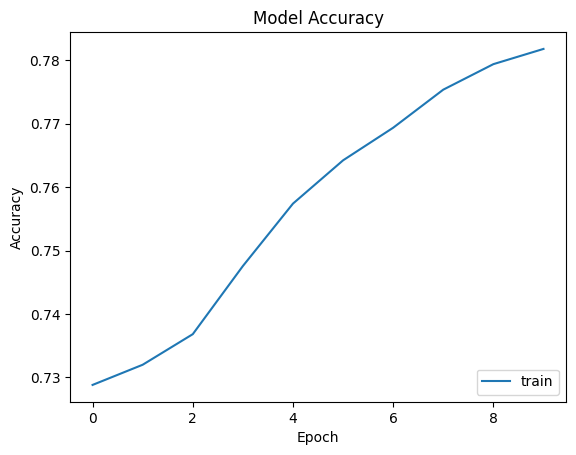

              precision    recall  f1-score   support

           0       0.14      0.04      0.07      1903
           1       0.00      0.00      0.00       697
           2       0.20      0.09      0.13      4464
           3       0.72      0.89      0.80     18349

    accuracy                           0.66     25413
   macro avg       0.26      0.26      0.25     25413
weighted avg       0.56      0.66      0.60     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_history(history1,model)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
2499/2499 [==============================] - 17s 6ms/step - loss: 0.3607 - accuracy: 0.7306
Epoch 2/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3388 - accuracy: 0.7314
Epoch 3/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3266 - accuracy: 0.7326
Epoch 4/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3172 - accuracy: 0.7372
Epoch 5/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3087 - accuracy: 0.7450
Epoch 6/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3019 - accuracy: 0.7523
Epoch 7/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.2952 - accuracy: 0.7576
Epoch 8/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.2905 - accuracy: 0.7632
Epoch 9/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.2863 - accuracy: 0.7655
Epoch 10/10
313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.2772 - accuracy: 0.7711
Epoch 1/10
2499/2499 [==============================] - 16s 5ms/step - loss: 0.3616 - accuracy: 0.7302
Epoch 2/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3393 - accuracy: 0.7313
Epoch 3/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3281 - accuracy: 0.7319
Epoch 4/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3191 - accuracy: 0.7341
Epoch 5/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3115 - accuracy: 0.7393
Epoch 6/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3048 - accuracy: 0.7441
Epoch 7/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.2995 - accuracy: 0.7507
Epoch 8/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.2949 - accuracy: 0.7558
Epoch 9/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.2900 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.2814 - accuracy: 0.7691
Epoch 1/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3604 - accuracy: 0.7304
Epoch 2/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3406 - accuracy: 0.7312
Epoch 3/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3295 - accuracy: 0.7308
Epoch 4/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3201 - accuracy: 0.7330
Epoch 5/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3131 - accuracy: 0.7390
Epoch 6/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3049 - accuracy: 0.7461
Epoch 7/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.2992 - accuracy: 0.7530
Epoch 8/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.2944 - accuracy: 0.7565
Epoch 9/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.2901 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.2828 - accuracy: 0.7717
Epoch 1/10
2499/2499 [==============================] - 17s 6ms/step - loss: 0.3629 - accuracy: 0.7295
Epoch 2/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3418 - accuracy: 0.7311
Epoch 3/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3289 - accuracy: 0.7304
Epoch 4/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3181 - accuracy: 0.7345
Epoch 5/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3081 - accuracy: 0.7411
Epoch 6/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3001 - accuracy: 0.7507
Epoch 7/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.2927 - accuracy: 0.7585
Epoch 8/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.2872 - accuracy: 0.7628
Epoch 9/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.2822 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.2770 - accuracy: 0.7748
Epoch 1/10
2499/2499 [==============================] - 16s 5ms/step - loss: 0.3612 - accuracy: 0.7305
Epoch 2/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3373 - accuracy: 0.7314
Epoch 3/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.3261 - accuracy: 0.7322
Epoch 4/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.3143 - accuracy: 0.7379
Epoch 5/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3060 - accuracy: 0.7449
Epoch 6/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.2985 - accuracy: 0.7532
Epoch 7/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.2905 - accuracy: 0.7617
Epoch 8/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.2853 - accuracy: 0.7657
Epoch 9/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.2813 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.2727 - accuracy: 0.7715


In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7716121638966371
Precision: 0.7224299746026798
Loss: 0.27824363112449646
Recall: 0.7716121638966371
F1-score: 0.7200304438657411


## **LSTM-DistilBERT-Titles**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(64, return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Flatten())
model2.add(Dense(4, activation='softmax'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
3124/3124 [==============================] - 55s 16ms/step - loss: 0.3289 - accuracy: 0.7331 - val_loss: 0.3767 - val_accuracy: 0.7184
Epoch 2/10
3124/3124 [==============================] - 49s 16ms/step - loss: 0.3001 - accuracy: 0.7474 - val_loss: 0.3969 - val_accuracy: 0.6694
Epoch 3/10
3124/3124 [==============================] - 49s 16ms/step - loss: 0.2829 - accuracy: 0.7663 - val_loss: 0.4210 - val_accuracy: 0.6385
Epoch 4/10
3124/3124 [==============================] - 50s 16ms/step - loss: 0.2721 - accuracy: 0.7747 - val_loss: 0.4220 - val_accuracy: 0.6626
Epoch 5/10
3124/3124 [==============================] - 51s 16ms/step - loss: 0.2656 - accuracy: 0.7816 - val_loss: 0.4505 - val_accuracy: 0.6224
Epoch 6/10
3124/3124 [==============================] - 50s 16ms/step - loss: 0.2602 - accuracy: 0.7873 - val_loss: 0.4545 - val_accuracy: 0.6377
Epoch 7/10
3124/3124 [==============================] - 48s 15ms/step - loss: 0.2569 - accuracy: 0.7900 - val_loss: 0.4233 -

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels)

y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 7s 7ms/step
Test Accuracy: 0.6052020788192749
Test F1 Score: 0.26451383384552424
Test Recall: 0.26615382544095967
Precision: 0.2870432969556381


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model2.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_112 (Conv1D)         (None, 764, 128)          768       
                                                                 
 max_pooling1d_112 (MaxPooli  (None, 382, 128)         0         
 ng1D)                                                           
                                                                 
 conv1d_113 (Conv1D)         (None, 378, 128)          82048     
                                                                 
 max_pooling1d_113 (MaxPooli  (None, 189, 128)         0         
 ng1D)                                                           
                                                                 
 lstm_12 (LSTM)              (None, 189, 64)           49408     
                                                                 
 batch_normalization_12 (Bat  (None, 189, 64)        

795/795 [==============================] - 6s 8ms/step
[[  207     1   157  1538]
 [   64     4    99   530]
 [  171    33   728  3532]
 [ 1244     0  2664 14441]]


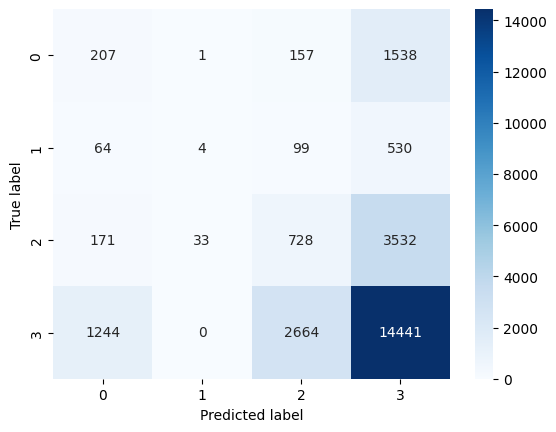

In [ ]:
y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

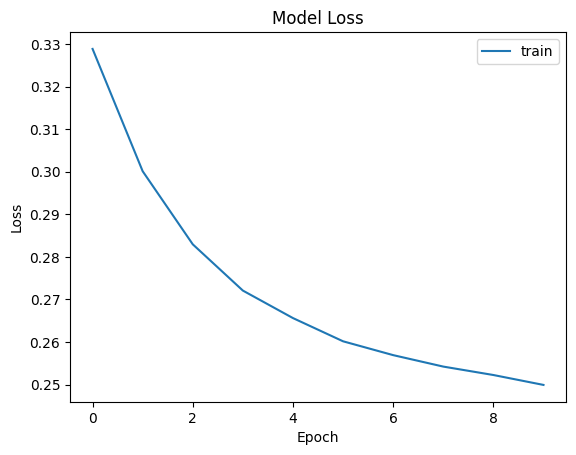

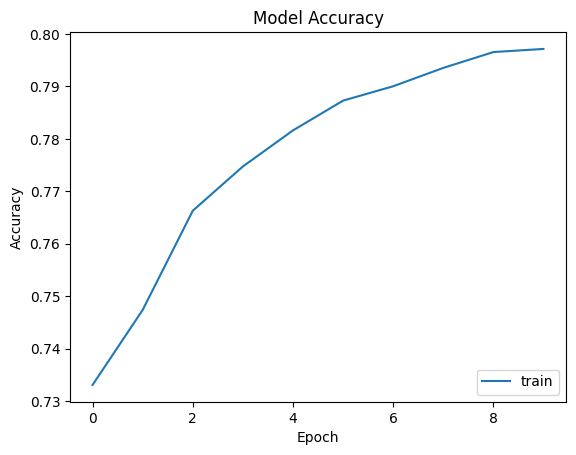

              precision    recall  f1-score   support

           0       0.12      0.11      0.12      1903
           1       0.11      0.01      0.01       697
           2       0.20      0.16      0.18      4464
           3       0.72      0.79      0.75     18349

    accuracy                           0.61     25413
   macro avg       0.29      0.27      0.26     25413
weighted avg       0.57      0.61      0.58     25413



In [ ]:
plot_history(history2,model2)

In [ ]:
def create_model():
  model2 = Sequential()
  model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(Conv1D(128, 5, activation='relu'))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(LSTM(64, return_sequences=True))
  model2.add(BatchNormalization())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dense(64, activation='relu'))
  model2.add(Dense(32, activation='relu'))
  model2.add(Flatten())
  model2.add(Dense(4, activation='softmax'))
  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model2


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
2499/2499 [==============================] - 35s 13ms/step - loss: 0.3312 - accuracy: 0.7323
Epoch 2/10
2499/2499 [==============================] - 32s 13ms/step - loss: 0.3057 - accuracy: 0.7456
Epoch 3/10
2499/2499 [==============================] - 33s 13ms/step - loss: 0.2889 - accuracy: 0.7585
Epoch 4/10
2499/2499 [==============================] - 31s 13ms/step - loss: 0.2769 - accuracy: 0.7686
Epoch 5/10
2499/2499 [==============================] - 31s 13ms/step - loss: 0.2685 - accuracy: 0.7788
Epoch 6/10
2499/2499 [==============================] - 32s 13ms/step - loss: 0.2639 - accuracy: 0.7829
Epoch 7/10
2499/2499 [==============================] - 32s 13ms/step - loss: 0.2604 - accuracy: 0.7858
Epoch 8/10
2499/2499 [==============================] - 32s 13ms/step - loss: 0.2565 - accuracy: 0.7910
Epoch 9/10
2499/2499 [==============================] - 33s 13ms/step - loss: 0.2535 - accuracy: 0.7928
Epoch 10/10
313/313 [==============================] - 3s 7ms/st

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7789763102483802
Precision: 0.7497107434436021
Loss: 0.2744024097919464
Recall: 0.7789763102483802
F1-score: 0.7479757858714189


## **FakeBert-DistilBERT-Titles**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(4, activation='softmax')(dropout2)
model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
3124/3124 [==============================] - 46s 14ms/step - loss: 0.3438 - accuracy: 0.7306 - val_loss: 0.3614 - val_accuracy: 0.7220
Epoch 2/10
3124/3124 [==============================] - 43s 14ms/step - loss: 0.3140 - accuracy: 0.7371 - val_loss: 0.3782 - val_accuracy: 0.7050
Epoch 3/10
3124/3124 [==============================] - 38s 12ms/step - loss: 0.2939 - accuracy: 0.7552 - val_loss: 0.3849 - val_accuracy: 0.6968
Epoch 4/10
3124/3124 [==============================] - 43s 14ms/step - loss: 0.2807 - accuracy: 0.7674 - val_loss: 0.3910 - val_accuracy: 0.6852
Epoch 5/10
3124/3124 [==============================] - 38s 12ms/step - loss: 0.2711 - accuracy: 0.7785 - val_loss: 0.4042 - val_accuracy: 0.6590
Epoch 6/10
3124/3124 [==============================] - 44s 14ms/step - loss: 0.2659 - accuracy: 0.7843 - val_loss: 0.3940 - val_accuracy: 0.7040
Epoch 7/10
3124/3124 [==============================] - 43s 14ms/step - loss: 0.2606 - accuracy: 0.7876 - val_loss: 0.4163 -

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels)

y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 4s 5ms/step
Test Accuracy: 0.6056349277496338
Test F1 Score: 0.25344309017176475
Test Recall: 0.2597210143792505
Precision: 0.2547428986092173


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model3.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_124 (Conv1D)            (None, 768, 128)     512         ['input_8[0][0]']                
                                                                                                  
 conv1d_125 (Conv1D)            (None, 768, 128)     640         ['input_8[0][0]']                
                                                                                                  
 conv1d_126 (Conv1D)            (None, 768, 128)     768         ['input_8[0][0]']                
                                                                                            

795/795 [==============================] - 4s 5ms/step
[[  233     0   105  1565]
 [   55     0    59   583]
 [  290     0   533  3641]
 [ 1832     0  1892 14625]]


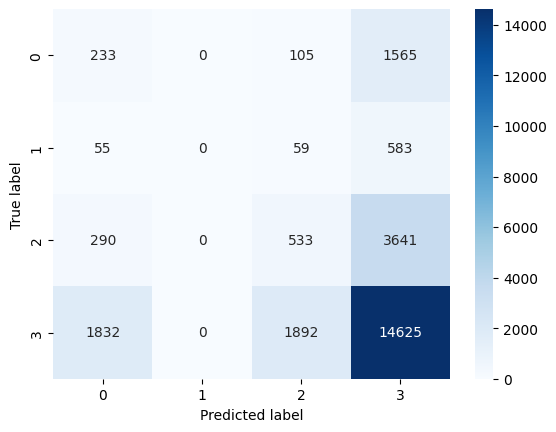

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  inputs = Input(shape=(768, 1))
  conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
  maxpool1 = MaxPooling1D(pool_size=2)(conv1)
  conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
  maxpool2 = MaxPooling1D(pool_size=2)(conv2)
  conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
  maxpool3 = MaxPooling1D(pool_size=2)(conv3)
  concat = Concatenate()([maxpool1, maxpool2, maxpool3])
  conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
  maxpool4 = MaxPooling1D(pool_size=2)(conv4)
  flatten = Flatten()(maxpool4)
  dense1 = Dense(384, activation='relu')(flatten)
  dropout1 = Dropout(0.5)(dense1)
  dense2 = Dense(128, activation='relu')(dropout1)
  dropout2 = Dropout(0.5)(dense2)
  output = Dense(4, activation='softmax')(dropout2)
  model3 = Model(inputs=inputs, outputs=output)
  model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model3

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)


Epoch 1/10
2499/2499 [==============================] - 28s 10ms/step - loss: 0.3487 - accuracy: 0.7306
Epoch 2/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.3234 - accuracy: 0.7333
Epoch 3/10
2499/2499 [==============================] - 25s 10ms/step - loss: 0.3051 - accuracy: 0.7434
Epoch 4/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2921 - accuracy: 0.7559
Epoch 5/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2824 - accuracy: 0.7659
Epoch 6/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2735 - accuracy: 0.7753
Epoch 7/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2674 - accuracy: 0.7798
Epoch 8/10
2499/2499 [==============================] - 25s 10ms/step - loss: 0.2645 - accuracy: 0.7837
Epoch 9/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2601 - accuracy: 0.7880
Epoch 10/10
313/313 [==============================] - 2s 7ms/st

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 3s 7ms/step - loss: 0.2553 - accuracy: 0.7914
Epoch 1/10
2499/2499 [==============================] - 30s 10ms/step - loss: 0.3477 - accuracy: 0.7304
Epoch 2/10
2499/2499 [==============================] - 25s 10ms/step - loss: 0.3219 - accuracy: 0.7344
Epoch 3/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.3035 - accuracy: 0.7458
Epoch 4/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2898 - accuracy: 0.7558
Epoch 5/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2781 - accuracy: 0.7698
Epoch 6/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2705 - accuracy: 0.7787
Epoch 7/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2633 - accuracy: 0.7841
Epoch 8/10
2499/2499 [==============================] - 25s 10ms/step - loss: 0.2602 - accuracy: 0.7878
Epoch 9/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 2s 6ms/step - loss: 0.2538 - accuracy: 0.7933
Epoch 1/10
2499/2499 [==============================] - 30s 10ms/step - loss: 0.3486 - accuracy: 0.7310
Epoch 2/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.3212 - accuracy: 0.7334
Epoch 3/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.3027 - accuracy: 0.7461
Epoch 4/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2896 - accuracy: 0.7594
Epoch 5/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2792 - accuracy: 0.7701
Epoch 6/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2703 - accuracy: 0.7798
Epoch 7/10
2499/2499 [==============================] - 25s 10ms/step - loss: 0.2649 - accuracy: 0.7826
Epoch 8/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2601 - accuracy: 0.7894
Epoch 9/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7965261458025391
Precision: 0.7733158121855013
Loss: 0.2518998712301254
Recall: 0.7965261458025391
F1-score: 0.7592383126945472


## **CNN Light - DistilBERT**

In [ ]:
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
model4.add(MaxPooling1D(pool_size = 2))
model4.add(Flatten())
model4.add(Dense(units=64, activation='relu'))
model4.add(Dense(units=4, activation='softmax'))

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_embeddings, train_labels, epochs=10, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/10
3124/3124 [==============================] - 18s 5ms/step - loss: 0.3283 - accuracy: 0.7330 - val_loss: 0.3684 - val_accuracy: 0.7228
Epoch 2/10
3124/3124 [==============================] - 16s 5ms/step - loss: 0.3069 - accuracy: 0.7421 - val_loss: 0.3825 - val_accuracy: 0.7209
Epoch 3/10
3124/3124 [==============================] - 15s 5ms/step - loss: 0.2948 - accuracy: 0.7512 - val_loss: 0.3943 - val_accuracy: 0.7214
Epoch 4/10
3124/3124 [==============================] - 15s 5ms/step - loss: 0.2835 - accuracy: 0.7605 - val_loss: 0.4014 - val_accuracy: 0.6756
Epoch 5/10
3124/3124 [==============================] - 17s 6ms/step - loss: 0.2762 - accuracy: 0.7697 - val_loss: 0.3977 - val_accuracy: 0.6993
Epoch 6/10
3124/3124 [==============================] - 15s 5ms/step - loss: 0.2711 - accuracy: 0.7741 - val_loss: 0.4095 - val_accuracy: 0.6594
Epoch 7/10
3124/3124 [==============================] - 18s 6ms/step - loss: 0.2650 - accuracy: 0.7801 - val_loss: 0.4405 - val_ac

In [ ]:
test_loss, test_acc = model4.evaluate(test_embeddings, test_labels)

y_pred = model4.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 1s 2ms/step
Test Accuracy: 0.6661550998687744
Test F1 Score: 0.25659536907632524
Test Recall: 0.26293927791140753
Precision: 0.2867443580151351


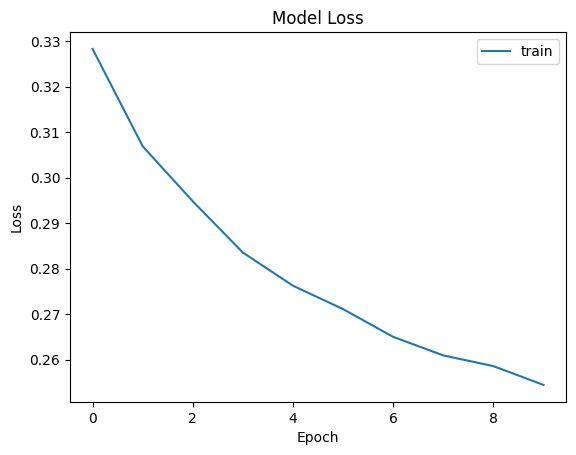

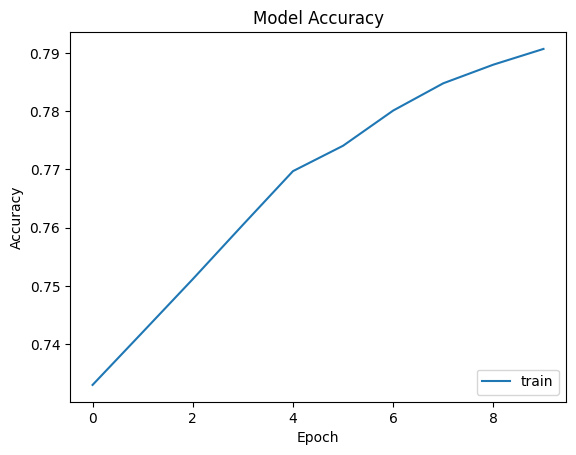

              precision    recall  f1-score   support

           0       0.13      0.05      0.07      1903
           1       0.10      0.03      0.05       697
           2       0.20      0.08      0.11      4464
           3       0.72      0.90      0.80     18349

    accuracy                           0.67     25413
   macro avg       0.29      0.26      0.26     25413
weighted avg       0.57      0.67      0.60     25413



In [ ]:
plot_history(history4,model4)

In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model4.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_111 (Conv1D)         (None, 766, 32)           128       
                                                                 
 max_pooling1d_111 (MaxPooli  (None, 383, 32)          0         
 ng1D)                                                           
                                                                 
 flatten_40 (Flatten)        (None, 12256)             0         
                                                                 
 dense_124 (Dense)           (None, 64)                784448    
                                                                 
 dense_125 (Dense)           (None, 4)                 260       
                                                                 
Total params: 784,836
Trainable params: 784,836
Non-trainable params: 0
_______________________________________________

795/795 [==============================] - 2s 2ms/step
[[   87    15    68  1733]
 [   35    22    27   613]
 [   60    86   341  3977]
 [  495   107  1268 16479]]


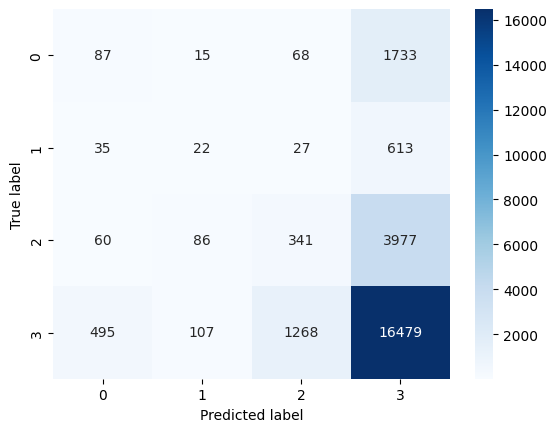

In [ ]:
y_pred = model4.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  model4 = Sequential()
  model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
  model4.add(MaxPooling1D(pool_size = 2))
  model4.add(Flatten())
  model4.add(Dense(units=64, activation='relu'))
  model4.add(Dense(units=4, activation='softmax'))
  model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model4


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
2499/2499 [==============================] - 10s 3ms/step - loss: 0.3307 - accuracy: 0.7313
Epoch 2/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.3128 - accuracy: 0.7385
Epoch 3/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.2999 - accuracy: 0.7462
Epoch 4/10
2499/2499 [==============================] - 9s 4ms/step - loss: 0.2896 - accuracy: 0.7564
Epoch 5/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.2816 - accuracy: 0.7630
Epoch 6/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.2756 - accuracy: 0.7678
Epoch 7/10
2499/2499 [==============================] - 9s 4ms/step - loss: 0.2703 - accuracy: 0.7738
Epoch 8/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.2664 - accuracy: 0.7787
Epoch 9/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.2621 - accuracy: 0.7825
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7755745953825421
Precision: 0.7554463611003291
Loss: 0.27261194586753845
Recall: 0.7755745953825421
F1-score: 0.7464897142352969


## **Bidirectional L2 LSTM-DistilBERT**

In [ ]:
model5 = Sequential()
model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(128, 5, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Bidirectional(LSTM(64, return_sequences=True)))
model5.add(BatchNormalization())
model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Flatten())
model5.add(Dense(4, activation='softmax'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 66s 19ms/step - loss: 0.3930 - accuracy: 0.7313
Epoch 2/10
3124/3124 [==============================] - 56s 18ms/step - loss: 0.3256 - accuracy: 0.7341
Epoch 3/10
3124/3124 [==============================] - 57s 18ms/step - loss: 0.3136 - accuracy: 0.7434
Epoch 4/10
3124/3124 [==============================] - 57s 18ms/step - loss: 0.3041 - accuracy: 0.7494
Epoch 5/10
3124/3124 [==============================] - 57s 18ms/step - loss: 0.2946 - accuracy: 0.7576
Epoch 6/10
3124/3124 [==============================] - 59s 19ms/step - loss: 0.2880 - accuracy: 0.7628
Epoch 7/10
3124/3124 [==============================] - 57s 18ms/step - loss: 0.2812 - accuracy: 0.7715
Epoch 8/10
3124/3124 [==============================] - 57s 18ms/step - loss: 0.2762 - accuracy: 0.7736
Epoch 9/10
3124/3124 [==============================] - 56s 18ms/step - loss: 0.2718 - accuracy: 0.7801
Epoch 10/10
3124/3124 [==============================] - 55s 18m

In [ ]:
test_loss, test_acc = model5.evaluate(test_embeddings, test_labels)

y_pred = model5.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 9s 10ms/step
Test Accuracy: 0.6417188048362732
Test F1 Score: 0.2642163871639729
Test Recall: 0.2668699907016032
Precision: 0.3550166004424885


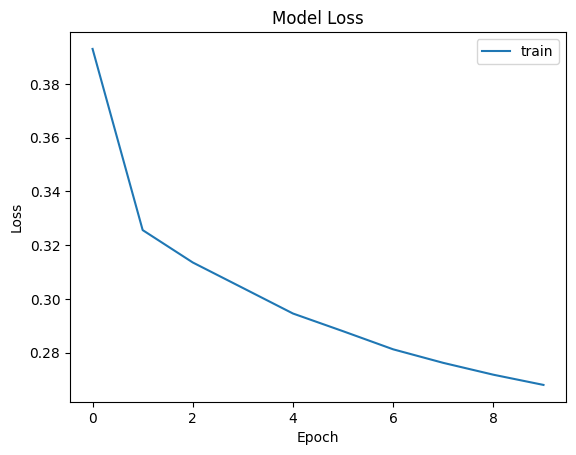

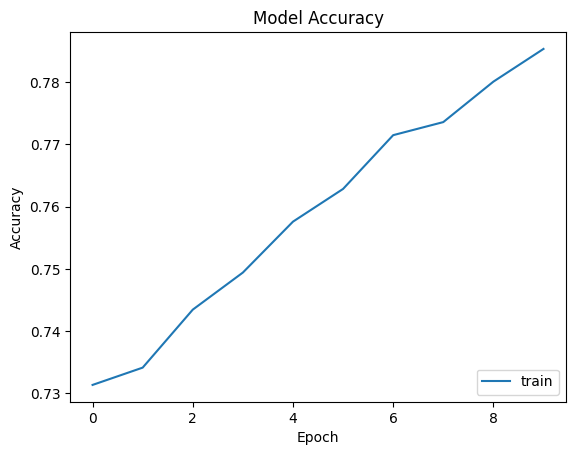

              precision    recall  f1-score   support

           0       0.14      0.06      0.09      1903
           1       0.33      0.00      0.01       697
           2       0.23      0.16      0.19      4464
           3       0.72      0.84      0.78     18349

    accuracy                           0.64     25413
   macro avg       0.36      0.27      0.26     25413
weighted avg       0.58      0.64      0.60     25413



In [ ]:
plot_history(history5,model5)

In [ ]:
model5.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_96 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_96 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_97 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_97 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 189, 128)         98816     
 nal)                                                            
                                                     

795/795 [==============================] - 8s 10ms/step
[[  122     4   117  1660]
 [   22     2    16   657]
 [   97     0   699  3668]
 [  662     0  2202 15485]]


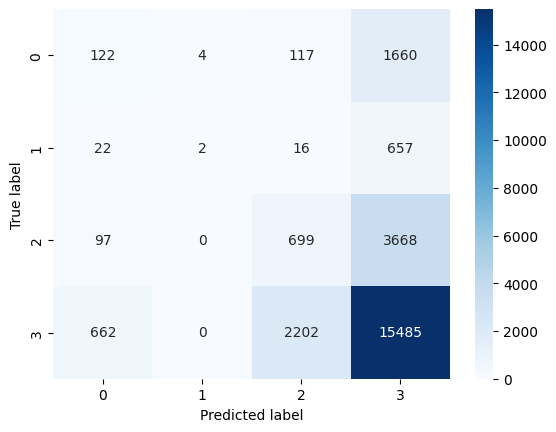

In [ ]:
y_pred = model5.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  model5 = Sequential()
  model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Conv1D(128, 5, activation='relu'))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Bidirectional(LSTM(64, return_sequences=True)))
  model5.add(BatchNormalization())
  model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Flatten())
  model5.add(Dense(4, activation='softmax'))
  model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model5


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
2499/2499 [==============================] - 50s 18ms/step - loss: 0.4093 - accuracy: 0.7309
Epoch 2/10
2499/2499 [==============================] - 46s 18ms/step - loss: 0.3278 - accuracy: 0.7338
Epoch 3/10
2499/2499 [==============================] - 45s 18ms/step - loss: 0.3162 - accuracy: 0.7398
Epoch 4/10
2499/2499 [==============================] - 45s 18ms/step - loss: 0.3063 - accuracy: 0.7458
Epoch 5/10
2499/2499 [==============================] - 46s 18ms/step - loss: 0.2968 - accuracy: 0.7556
Epoch 6/10
2499/2499 [==============================] - 45s 18ms/step - loss: 0.2894 - accuracy: 0.7633
Epoch 7/10
2499/2499 [==============================] - 46s 18ms/step - loss: 0.2832 - accuracy: 0.7682
Epoch 8/10
2499/2499 [==============================] - 45s 18ms/step - loss: 0.2770 - accuracy: 0.7762
Epoch 9/10
2499/2499 [==============================] - 44s 18ms/step - loss: 0.2720 - accuracy: 0.7807
Epoch 10/10
313/313 [==============================] - 4s 10ms/s

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7718922819424521
Precision: 0.7461707734451002
Loss: 0.2781911313533783
Recall: 0.7718922819424521
F1-score: 0.7370518704695548


## **L2 CNN-DistilBERT**

In [ ]:
# build the model
model6 = Sequential()
model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Flatten())
model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(4, activation='softmax'))

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 19s 5ms/step - loss: 0.4069 - accuracy: 0.7296
Epoch 2/10
3124/3124 [==============================] - 18s 6ms/step - loss: 0.3479 - accuracy: 0.7313
Epoch 3/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.3433 - accuracy: 0.7313
Epoch 4/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.3390 - accuracy: 0.7311
Epoch 5/10
3124/3124 [==============================] - 17s 6ms/step - loss: 0.3331 - accuracy: 0.7317
Epoch 6/10
3124/3124 [==============================] - 19s 6ms/step - loss: 0.3279 - accuracy: 0.7332
Epoch 7/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.3236 - accuracy: 0.7358
Epoch 8/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.3205 - accuracy: 0.7380
Epoch 9/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.3174 - accuracy: 0.7422
Epoch 10/10
3124/3124 [==============================] - 18s 6ms/step - l

In [ ]:
test_loss, test_acc = model6.evaluate(test_embeddings, test_labels)

y_pred = model6.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 2s 2ms/step
Test Accuracy: 0.7049148082733154
Test F1 Score: 0.21999852959356106
Test Recall: 0.2499639085299737
Precision: 0.22555780362396025


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


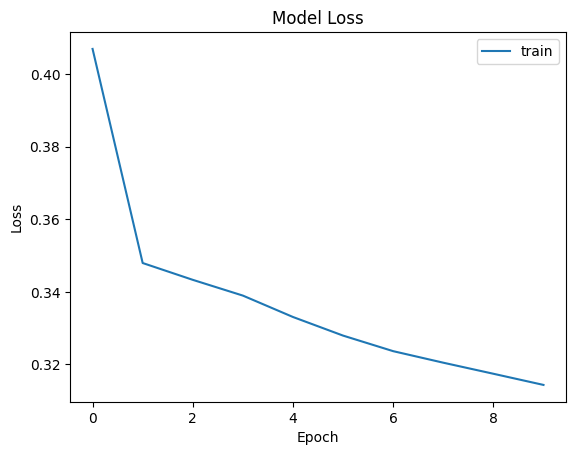

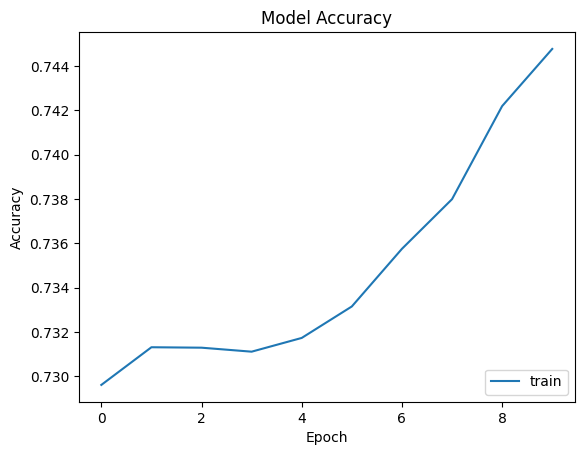

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1903
           1       0.00      0.00      0.00       697
           2       0.18      0.03      0.05      4464
           3       0.72      0.97      0.83     18349

    accuracy                           0.70     25413
   macro avg       0.23      0.25      0.22     25413
weighted avg       0.55      0.70      0.61     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_history(history6,model6)

In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model6.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_108 (Conv1D)         (None, 764, 128)          768       
                                                                 
 max_pooling1d_108 (MaxPooli  (None, 152, 128)         0         
 ng1D)                                                           
                                                                 
 conv1d_109 (Conv1D)         (None, 148, 128)          82048     
                                                                 
 max_pooling1d_109 (MaxPooli  (None, 29, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_110 (Conv1D)         (None, 25, 128)           82048     
                                                                 
 max_pooling1d_110 (MaxPooli  (None, 5, 128)         

795/795 [==============================] - 2s 2ms/step
[[    0     0    36  1867]
 [    0     0    19   678]
 [    0     0   139  4325]
 [    0     0   574 17775]]


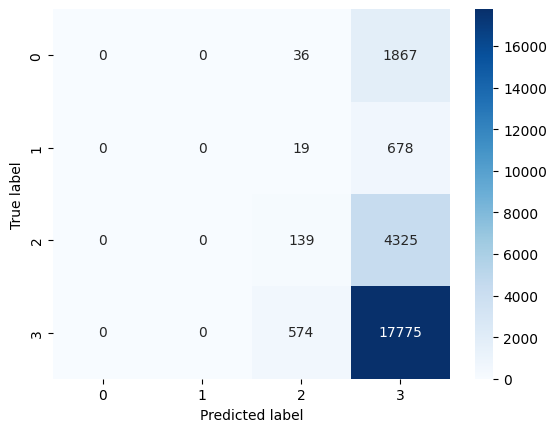

In [ ]:
y_pred = model6.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  model6 = Sequential()
  model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Flatten())
  model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(4, activation='softmax'))
  model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model6


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
2499/2499 [==============================] - 18s 6ms/step - loss: 0.4226 - accuracy: 0.7306
Epoch 2/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.3485 - accuracy: 0.7313
Epoch 3/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3447 - accuracy: 0.7313
Epoch 4/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3397 - accuracy: 0.7311
Epoch 5/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3364 - accuracy: 0.7307
Epoch 6/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3339 - accuracy: 0.7307
Epoch 7/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3313 - accuracy: 0.7319
Epoch 8/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3282 - accuracy: 0.7322
Epoch 9/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3259 - accuracy: 0.7328
Epoch 10/10
313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 4ms/step - loss: 0.3229 - accuracy: 0.7315
Epoch 1/10
2499/2499 [==============================] - 17s 6ms/step - loss: 0.4207 - accuracy: 0.7301
Epoch 2/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3486 - accuracy: 0.7313
Epoch 3/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3434 - accuracy: 0.7311
Epoch 4/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3398 - accuracy: 0.7308
Epoch 5/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3343 - accuracy: 0.7307
Epoch 6/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3305 - accuracy: 0.7325
Epoch 7/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3275 - accuracy: 0.7344
Epoch 8/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3241 - accuracy: 0.7383
Epoch 9/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3222 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 2s 4ms/step - loss: 0.3206 - accuracy: 0.7399
Epoch 1/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.4186 - accuracy: 0.7293
Epoch 2/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3488 - accuracy: 0.7313
Epoch 3/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3447 - accuracy: 0.7311
Epoch 4/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3399 - accuracy: 0.7317
Epoch 5/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3354 - accuracy: 0.7325
Epoch 6/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3312 - accuracy: 0.7345
Epoch 7/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3273 - accuracy: 0.7360
Epoch 8/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3245 - accuracy: 0.7387
Epoch 9/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3218 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.3079 - accuracy: 0.7578
Epoch 1/10
2499/2499 [==============================] - 18s 6ms/step - loss: 0.4189 - accuracy: 0.7301
Epoch 2/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.3498 - accuracy: 0.7313
Epoch 3/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3453 - accuracy: 0.7313
Epoch 4/10
2499/2499 [==============================] - 16s 7ms/step - loss: 0.3420 - accuracy: 0.7312
Epoch 5/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3378 - accuracy: 0.7310
Epoch 6/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3339 - accuracy: 0.7310
Epoch 7/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3301 - accuracy: 0.7307
Epoch 8/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3267 - accuracy: 0.7322
Epoch 9/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.3247 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 2s 4ms/step - loss: 0.3227 - accuracy: 0.7326
Epoch 1/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.4210 - accuracy: 0.7293
Epoch 2/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3488 - accuracy: 0.7313
Epoch 3/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3446 - accuracy: 0.7313
Epoch 4/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.3393 - accuracy: 0.7312
Epoch 5/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3358 - accuracy: 0.7316
Epoch 6/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3310 - accuracy: 0.7329
Epoch 7/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3275 - accuracy: 0.7348
Epoch 8/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3230 - accuracy: 0.7390
Epoch 9/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.3202 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 2s 4ms/step - loss: 0.3086 - accuracy: 0.7566


In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7436567673470516
Precision: 0.6576982686810119
Loss: 0.3165394842624664
Recall: 0.7436567673470516
F1-score: 0.6685874686534844


# **Text-Title-DistilBERT**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_title_distilbert.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_title_distilbert.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_title_distilbert.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_title_distilbert.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
train_labels.shape

(49972,)

In [ ]:
train_labels = to_categorical(train_labels, num_classes=4)
test_labels = to_categorical(test_labels, num_classes=4)

In [ ]:
train_labels.shape

(49972, 4)

In [ ]:
train_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_distilbert.npy')
train_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_distilbert.npy')
test_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_distilbert.npy')
test_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_distilbert.npy')

In [ ]:
train_embeddings1 = tf.expand_dims(train_embeddings1, axis=-1)
test_embeddings1 = tf.expand_dims(test_embeddings1, axis=-1)

In [ ]:
train_embeddings1.shape

TensorShape([49972, 768, 1])

In [ ]:
train_labels1.shape

(49972,)

In [ ]:
title_input = Input(shape=(768,), name='title_bert')
text_input = Input(shape=(768,), name='text_bert')
shared_dense = Dense(768, activation='relu')
title_output = shared_dense(title_input)
text_output = shared_dense(text_input)
concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
dropped_out = Dropout(0.5)(concatenated)
output = Dense(4, activation='softmax', name='output')(dropped_out)
model = Model(inputs=[title_input, text_input], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=[tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)],
          y=train_labels,
          epochs=9,
          batch_size=16)

Epoch 1/9
3124/3124 [==============================] - 16s 5ms/step - loss: 0.3346 - accuracy: 0.7315
Epoch 2/9
3124/3124 [==============================] - 15s 5ms/step - loss: 0.3211 - accuracy: 0.7333
Epoch 3/9
3124/3124 [==============================] - 15s 5ms/step - loss: 0.3138 - accuracy: 0.7365
Epoch 4/9
3124/3124 [==============================] - 15s 5ms/step - loss: 0.3066 - accuracy: 0.7379
Epoch 5/9
3124/3124 [==============================] - 18s 6ms/step - loss: 0.3015 - accuracy: 0.7435
Epoch 6/9
3124/3124 [==============================] - 16s 5ms/step - loss: 0.2961 - accuracy: 0.7470
Epoch 7/9
3124/3124 [==============================] - 16s 5ms/step - loss: 0.2925 - accuracy: 0.7490
Epoch 8/9
3124/3124 [==============================] - 14s 5ms/step - loss: 0.2880 - accuracy: 0.7505
Epoch 9/9
3124/3124 [==============================] - 15s 5ms/step - loss: 0.2848 - accuracy: 0.7539


In [ ]:
a = np.asarray(test_labels).argmax(axis=1)

In [ ]:
test_loss, test_acc = model.evaluate([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)], test_labels, verbose=2)

y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 - 2s - loss: 0.3910 - accuracy: 0.7169 - 2s/epoch - 2ms/step
795/795 [==============================] - 2s 3ms/step
Test Accuracy: 0.716916561126709
Test F1 Score: 0.22689243938143677
Test Recall: 0.25594223865996196
Precision: 0.31144206919250206


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_bert (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 text_bert (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 768)          590592      ['title_bert[0][0]',             
                                                                  'text_bert[0][0]']              
                                                                                                  
 concatenated (Concatenate)     (None, 1536)         0           ['dense_9[0][0]',          

795/795 [==============================] - 2s 3ms/step
[[   18     0    21  1864]
 [   18     0     4   675]
 [    8     0   132  4324]
 [  111     0   169 18069]]


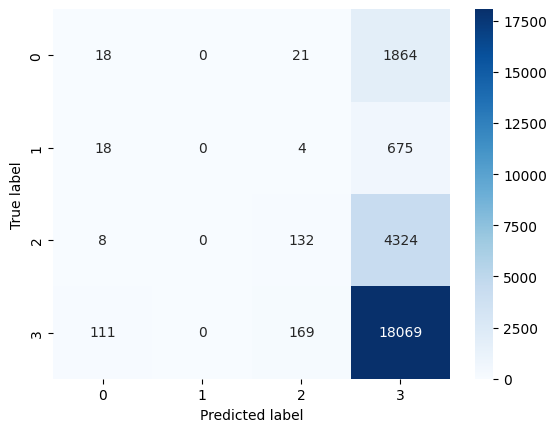

In [ ]:
y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  title_input = Input(shape=(768,), name='title_bert')
  text_input = Input(shape=(768,), name='text_bert')
  shared_dense = Dense(768, activation='relu')
  title_output = shared_dense(title_input)
  text_output = shared_dense(text_input)
  concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
  dropped_out = Dropout(0.5)(concatenated)
  output = Dense(4, activation='softmax', name='output')(dropped_out)
  model = Model(inputs=[title_input, text_input], outputs=output)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit([tf.gather(train_embeddings, train_index), tf.gather(train_embeddings1, train_index)],np.asarray(train_labels)[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict([tf.gather(train_embeddings, test_index), tf.gather(train_embeddings1, test_index)])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels,average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate([tf.gather(train_embeddings, test_index), tf.gather(train_embeddings1, test_index)])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
2499/2499 [==============================] - 29s 10ms/step - loss: 0.3359 - accuracy: 0.7316
Epoch 2/10
2499/2499 [==============================] - 22s 9ms/step - loss: 0.3236 - accuracy: 0.7337
Epoch 3/10
2499/2499 [==============================] - 19s 8ms/step - loss: 0.3164 - accuracy: 0.7352
Epoch 4/10
2499/2499 [==============================] - 21s 8ms/step - loss: 0.3100 - accuracy: 0.7377
Epoch 5/10
2499/2499 [==============================] - 18s 7ms/step - loss: 0.3051 - accuracy: 0.7392
Epoch 6/10
2499/2499 [==============================] - 19s 8ms/step - loss: 0.3023 - accuracy: 0.7424
Epoch 7/10
2499/2499 [==============================] - 19s 8ms/step - loss: 0.2976 - accuracy: 0.7451
Epoch 8/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.2927 - accuracy: 0.7476
Epoch 9/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.2893 - accuracy: 0.7502
Epoch 10/10
313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 1/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3354 - accuracy: 0.7317
Epoch 2/10
2499/2499 [==============================] - 11s 5ms/step - loss: 0.3223 - accuracy: 0.7340
Epoch 3/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3154 - accuracy: 0.7358
Epoch 4/10
2499/2499 [==============================] - 11s 5ms/step - loss: 0.3096 - accuracy: 0.7377
Epoch 5/10
2499/2499 [==============================] - 11s 5ms/step - loss: 0.3042 - accuracy: 0.7418
Epoch 6/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.2992 - accuracy: 0.7425
Epoch 7/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.2958 - accuracy: 0.7468
Epoch 8/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.2931 - accuracy: 0.7493
Epoch 9/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7574441793640466
Precision: 0.7498364271492876
Loss: 0.0
Recall: 0.7574441793640466
F1-score: 0.686046594011488


# Max-Worth-Title-DistilBERT

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_max_distilbert.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_max_distilbert.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_max_distilbert.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_max_distilbert.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
train_labels.shape

(49972,)

In [ ]:
train_labels = to_categorical(train_labels, num_classes=4)
test_labels = to_categorical(test_labels, num_classes=4)

In [ ]:
train_labels.shape

(49972, 4)

In [ ]:
train_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_max_distilbert.npy')
train_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_max_distilbert.npy')
test_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_max_distilbert.npy')
test_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_max_distilbert.npy')

In [ ]:
train_embeddings1 = tf.expand_dims(train_embeddings1, axis=-1)
test_embeddings1 = tf.expand_dims(test_embeddings1, axis=-1)

In [ ]:
train_embeddings1.shape

TensorShape([49972, 768, 1])

In [ ]:
train_labels1.shape

(49972,)

In [ ]:
title_input = Input(shape=(768,), name='title_bert')
text_input = Input(shape=(768,), name='text_bert')
shared_dense = Dense(768, activation='relu')
title_output = shared_dense(title_input)
text_output = shared_dense(text_input)
concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
dropped_out = Dropout(0.5)(concatenated)
output = Dense(4, activation='softmax', name='output')(dropped_out)
model = Model(inputs=[title_input, text_input], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=[tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)],
          y=train_labels,
          epochs=9,
          batch_size=16)

Epoch 1/9
3124/3124 [==============================] - 26s 7ms/step - loss: 0.3386 - accuracy: 0.7300
Epoch 2/9
3124/3124 [==============================] - 21s 7ms/step - loss: 0.3263 - accuracy: 0.7321
Epoch 3/9
3124/3124 [==============================] - 16s 5ms/step - loss: 0.3188 - accuracy: 0.7357
Epoch 4/9
3124/3124 [==============================] - 15s 5ms/step - loss: 0.3135 - accuracy: 0.7390
Epoch 5/9
3124/3124 [==============================] - 16s 5ms/step - loss: 0.3083 - accuracy: 0.7412
Epoch 6/9
3124/3124 [==============================] - 16s 5ms/step - loss: 0.3044 - accuracy: 0.7453
Epoch 7/9
3124/3124 [==============================] - 15s 5ms/step - loss: 0.3011 - accuracy: 0.7465
Epoch 8/9
3124/3124 [==============================] - 15s 5ms/step - loss: 0.2970 - accuracy: 0.7480
Epoch 9/9
3124/3124 [==============================] - 15s 5ms/step - loss: 0.2945 - accuracy: 0.7494


In [ ]:
test_loss, test_acc = model.evaluate([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)], test_labels, verbose=2)

y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 - 2s - loss: 0.3814 - accuracy: 0.7133 - 2s/epoch - 3ms/step
795/795 [==============================] - 2s 2ms/step
Test Accuracy: 0.7132963538169861
Test F1 Score: 0.2246004045616271
Test Recall: 0.2540949610801796
Precision: 0.2530941662914545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_bert (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 text_bert (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 dense_11 (Dense)               (None, 768)          590592      ['title_bert[0][0]',             
                                                                  'text_bert[0][0]']              
                                                                                                  
 concatenated (Concatenate)     (None, 1536)         0           ['dense_11[0][0]',        

795/795 [==============================] - 2s 2ms/step
[[    0     0    19  1884]
 [    0     0     4   693]
 [    0     0   168  4296]
 [    0     0   390 17959]]


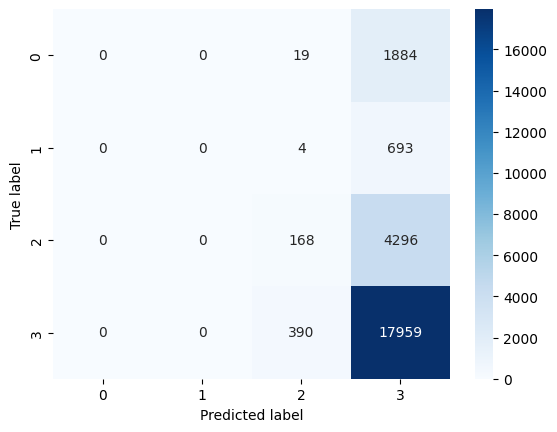

In [ ]:
y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  title_input = Input(shape=(768,), name='title_bert')
  text_input = Input(shape=(768,), name='text_bert')
  shared_dense = Dense(768, activation='relu')
  title_output = shared_dense(title_input)
  text_output = shared_dense(text_input)
  concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
  dropped_out = Dropout(0.5)(concatenated)
  output = Dense(4, activation='softmax', name='output')(dropped_out)
  model = Model(inputs=[title_input, text_input], outputs=output)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit([tf.gather(train_embeddings, train_index), tf.gather(train_embeddings1, train_index)],np.asarray(train_labels)[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict([tf.gather(train_embeddings, test_index), tf.gather(train_embeddings1, test_index)])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels,average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate([tf.gather(train_embeddings, test_index), tf.gather(train_embeddings1, test_index)])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3403 - accuracy: 0.7305
Epoch 2/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3291 - accuracy: 0.7327
Epoch 3/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.3229 - accuracy: 0.7354
Epoch 4/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3169 - accuracy: 0.7383
Epoch 5/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3122 - accuracy: 0.7408
Epoch 6/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3081 - accuracy: 0.7420
Epoch 7/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3047 - accuracy: 0.7455
Epoch 8/10
2499/2499 [==============================] - 11s 5ms/step - loss: 0.3017 - accuracy: 0.7473
Epoch 9/10
2499/2499 [==============================] - 11s 5ms/step - loss: 0.2980 - accuracy: 0.7495
Epoch 10/10
313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 1/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3400 - accuracy: 0.7303
Epoch 2/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3294 - accuracy: 0.7325
Epoch 3/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3232 - accuracy: 0.7350
Epoch 4/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3169 - accuracy: 0.7369
Epoch 5/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.3133 - accuracy: 0.7401
Epoch 6/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3095 - accuracy: 0.7424
Epoch 7/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3055 - accuracy: 0.7431
Epoch 8/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3016 - accuracy: 0.7455
Epoch 9/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 1/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3409 - accuracy: 0.7301
Epoch 2/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3297 - accuracy: 0.7316
Epoch 3/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3239 - accuracy: 0.7352
Epoch 4/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3182 - accuracy: 0.7384
Epoch 5/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3131 - accuracy: 0.7413
Epoch 6/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.3089 - accuracy: 0.7427
Epoch 7/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3056 - accuracy: 0.7443
Epoch 8/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3029 - accuracy: 0.7477
Epoch 9/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 1/10
2499/2499 [==============================] - 12s 4ms/step - loss: 0.3402 - accuracy: 0.7300
Epoch 2/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3295 - accuracy: 0.7316
Epoch 3/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3237 - accuracy: 0.7336
Epoch 4/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3180 - accuracy: 0.7351
Epoch 5/10
2499/2499 [==============================] - 11s 5ms/step - loss: 0.3132 - accuracy: 0.7375
Epoch 6/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.3094 - accuracy: 0.7409
Epoch 7/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3062 - accuracy: 0.7438
Epoch 8/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3036 - accuracy: 0.7449
Epoch 9/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 1/10
2499/2499 [==============================] - 12s 4ms/step - loss: 0.3401 - accuracy: 0.7294
Epoch 2/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.3294 - accuracy: 0.7323
Epoch 3/10
2499/2499 [==============================] - 11s 5ms/step - loss: 0.3232 - accuracy: 0.7332
Epoch 4/10
2499/2499 [==============================] - 11s 5ms/step - loss: 0.3179 - accuracy: 0.7356
Epoch 5/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.3140 - accuracy: 0.7376
Epoch 6/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.3104 - accuracy: 0.7416
Epoch 7/10
2499/2499 [==============================] - 11s 5ms/step - loss: 0.3057 - accuracy: 0.7430
Epoch 8/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.3025 - accuracy: 0.7437
Epoch 9/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7574441793640466
Precision: 0.7498364271492876
Loss: 0.0
Recall: 0.7574441793640466
F1-score: 0.686046594011488


# Dataset Binary

## **train data**

In [ ]:
path = '/content/drive/MyDrive/FakeNewsChallenge/final_max.csv'
df = pd.read_csv(path,delimiter=',')

In [ ]:
df.head()

,Headline,Stance,articleBody,max
0,Police find mass graves with at least '15 bodi...,3,Danny Boyle is directing the untitled film\n\n...,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,0,Hundreds of Palestinians were evacuated from t...,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",3,30-year-old Moscow resident was hospitalized w...,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,3,(Reuters) - A Canadian soldier was shot at the...,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1,"Fear not arachnophobes, the story of Bunbury's...",Perth scientists have cast doubt over claims t...


In [ ]:
df['Stance'] = df['Stance'].apply(lambda x: 1 if x in [0, 2] else 0)

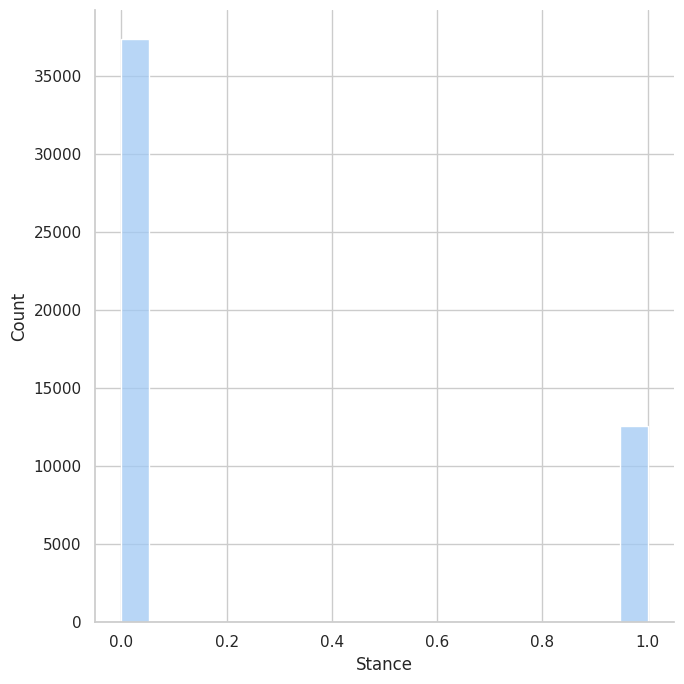

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df, x="Stance",height=7,aspect=1)

## **test data**

In [ ]:
path = '/content/drive/MyDrive/FakeNewsChallenge/final_max1.csv'
df1 = pd.read_csv(path,delimiter=',')

In [ ]:
df1['Stance'] = df1['Stance'].apply(lambda x: 1 if x in [0, 2] else 0)

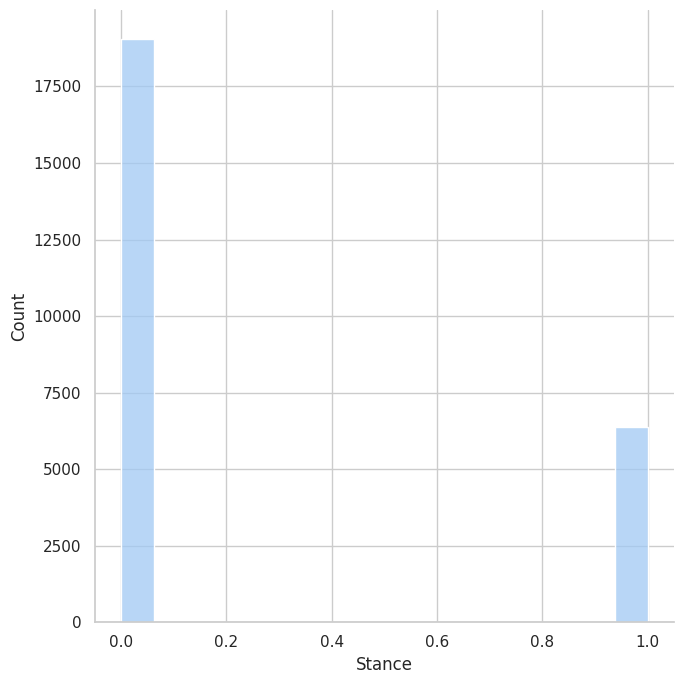

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df1, x="Stance",height=7,aspect=1)

## DistilBERT Train

In [ ]:
tokenizer_distil = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2,output_hidden_states=True)

for layer in model_distil.layers[:-3]:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
df['articleBody'] = df['articleBody'].astype(str)
df1['articleBody'] = df1['articleBody'].astype(str)

In [ ]:
train_encodings = tokenizer_distil(df['articleBody'].tolist(), truncation = True, padding = True  )

test_encodings = tokenizer_distil(df1['articleBody'].tolist(), truncation = True, padding = True  )


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    df['Stance'].tolist()
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    df1['Stance'].tolist()
))

In [ ]:
train_dataset = train_dataset.batch(2)
test_dataset = test_dataset.batch(2)

In [ ]:
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(train_dataset, batch_size=2, epochs=2)

Epoch 1/2
24986/24986 [==============================] - 1407s 56ms/step - loss: 0.5588 - accuracy: 0.7481
Epoch 2/2
24986/24986 [==============================] - 1393s 56ms/step - loss: 0.5509 - accuracy: 0.7481


In [ ]:
benchmarks = model_distil.evaluate(test_dataset, return_dict=True, batch_size=2)

12707/12707 [==============================] - 635s 50ms/step - loss: 0.5701 - accuracy: 0.7495


In [ ]:
model_distil.save_pretrained('/content/drive/MyDrive/FakeNewsChallenge/distil_binary_text')

## **DistilBERT Embeddings**

In [ ]:
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

In [ ]:
model_path = '/content/drive/MyDrive/FakeNewsChallenge/distil_binary_text'

model_distil = TFDistilBertForSequenceClassification.from_pretrained(model_path)

Some layers from the model checkpoint at /content/drive/MyDrive/FakeNewsChallenge/distil_binary_text were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/FakeNewsChallenge/distil_binary_text and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

## DistilBERT train titles embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['Headline'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 25174/25174 [47:16<00:00,  8.87it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_title_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_train_title_bin.npy', labels)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=42)
df, df['Stance'] = ros.fit_resample(df, df['Stance'])

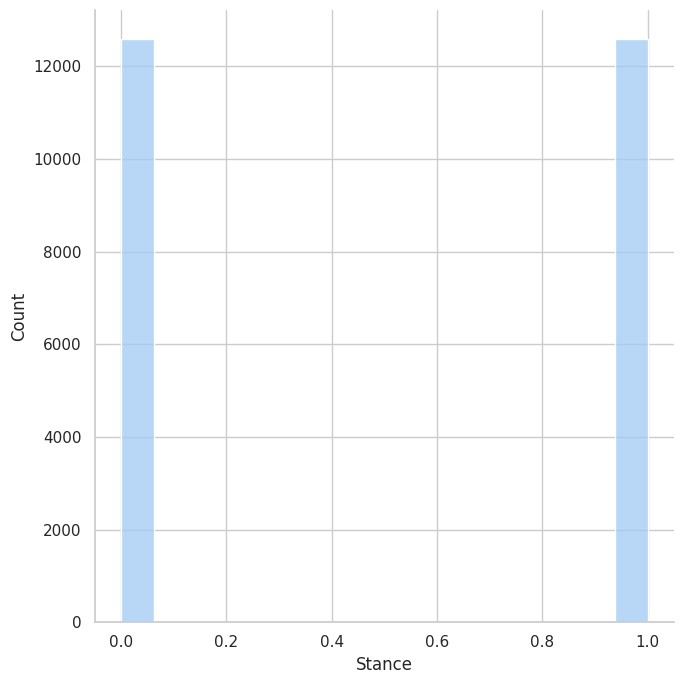

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df, x="Stance",height=7,aspect=1)

## DistilBERT test titles embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df1['Headline'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 12734/12734 [25:28<00:00,  8.33it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df1['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_title_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_test_title_bin.npy', labels)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=42)
df1, df1['Stance'] = ros.fit_resample(df1, df1['Stance'])

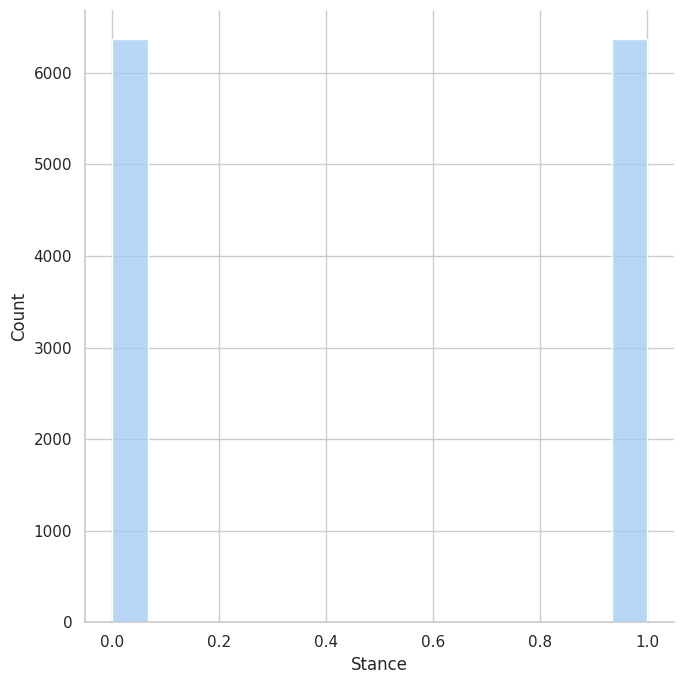

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df1, x="Stance",height=7,aspect=1)

## DistilBERT train text embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['articleBody'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 49972/49972 [1:35:53<00:00,  8.69it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_distilbert_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_distilbert_bin.npy', labels)

## DistilBERT test text embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df1['articleBody'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df1['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_distilbert_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_distilbert_bin.npy', labels)

## DistilBERT train max-worth embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['max'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 49972/49972 [1:36:12<00:00,  8.66it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_max_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_max_bin.npy', labels)

## DistilBERT test max-worth embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df1['max'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = str(titles[i:i+batch_size])

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 25413/25413 [49:34<00:00,  8.54it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df1['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_max_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_max_bin.npy', labels)

# Texts

## **CNN-DistilBERT**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_distilbert_bin.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_distilbert_bin.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_distilbert_bin.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_distilbert_bin.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 23s 6ms/step - loss: 0.5593 - accuracy: 0.7480
Epoch 2/10
3124/3124 [==============================] - 19s 6ms/step - loss: 0.5358 - accuracy: 0.7487
Epoch 3/10
3124/3124 [==============================] - 21s 7ms/step - loss: 0.5138 - accuracy: 0.7587
Epoch 4/10
3124/3124 [==============================] - 19s 6ms/step - loss: 0.4956 - accuracy: 0.7746
Epoch 5/10
3124/3124 [==============================] - 19s 6ms/step - loss: 0.4809 - accuracy: 0.7861
Epoch 6/10
3124/3124 [==============================] - 19s 6ms/step - loss: 0.4698 - accuracy: 0.7944
Epoch 7/10
3124/3124 [==============================] - 19s 6ms/step - loss: 0.4625 - accuracy: 0.7990
Epoch 8/10
3124/3124 [==============================] - 19s 6ms/step - loss: 0.4563 - accuracy: 0.8036
Epoch 9/10
3124/3124 [==============================] - 20s 6ms/step - loss: 0.4503 - accuracy: 0.8083
Epoch 10/10
3124/3124 [==============================] - 19s 6ms/step - l

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 3s 3ms/step
Test Accuracy: 0.6850824356079102
Test F1 Score: 0.23860717343735136
Test Recall: 0.1969530391079001
Precision: 0.3026061776061776


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 152, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 29, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 5, 128)          

795/795 [==============================] - 2s 2ms/step
[[16156  2890]
 [ 5113  1254]]


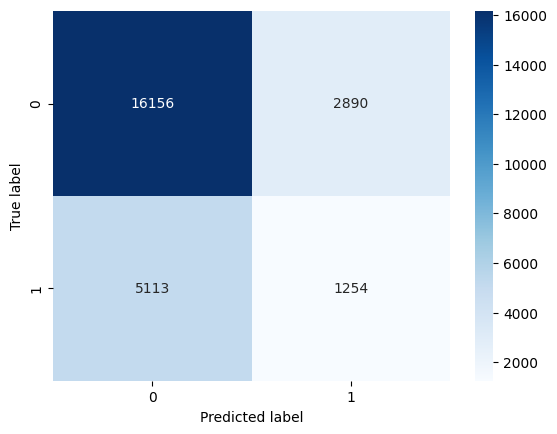

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(test_embeddings)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(test_labels, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()

    # Print the classification report
    print(classification_report(test_labels, y_pred))

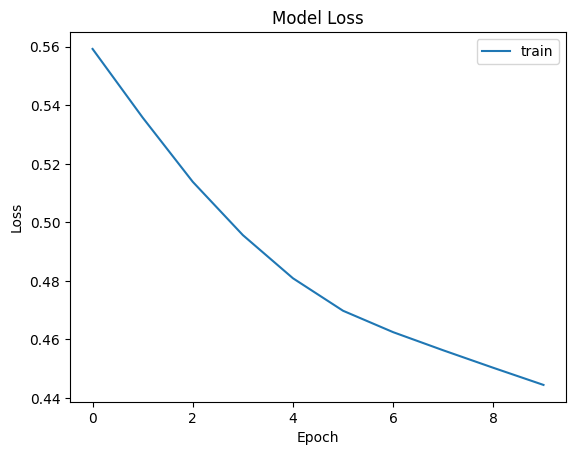

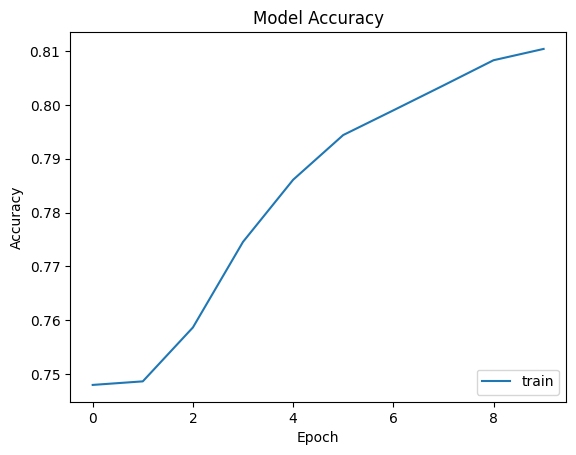

795/795 [==============================] - 2s 2ms/step


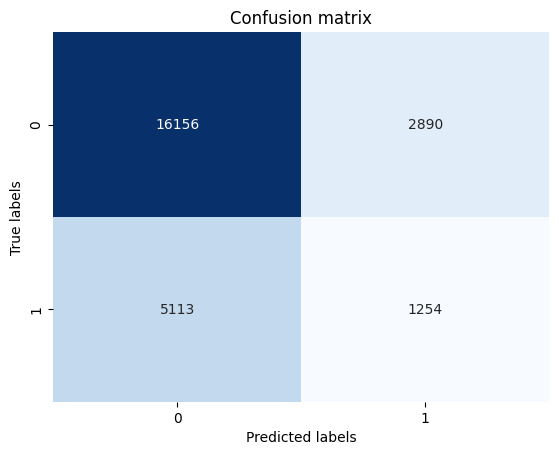

              precision    recall  f1-score   support

           0       0.76      0.85      0.80     19046
           1       0.30      0.20      0.24      6367

    accuracy                           0.69     25413
   macro avg       0.53      0.52      0.52     25413
weighted avg       0.65      0.69      0.66     25413



In [ ]:
plot_history(history1,model)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
2499/2499 [==============================] - 19s 6ms/step - loss: 0.5628 - accuracy: 0.7479
Epoch 2/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.5470 - accuracy: 0.7480
Epoch 3/10
2499/2499 [==============================] - 19s 8ms/step - loss: 0.5309 - accuracy: 0.7497
Epoch 4/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5188 - accuracy: 0.7566
Epoch 5/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5051 - accuracy: 0.7641
Epoch 6/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.4964 - accuracy: 0.7728
Epoch 7/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.4875 - accuracy: 0.7787
Epoch 8/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.4777 - accuracy: 0.7857
Epoch 9/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.4710 - accuracy: 0.7897
Epoch 10/10
625/625 [==============================] - 1s 2ms/step
Epoch 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.80 (+/- 0.01)
Cross-Validation Precision: 0.70 (+/- 0.08)
Cross-Validation Loss: 0.47 (+/- 0.02)
Cross-Validation Recall: 0.34 (+/- 0.09)
Cross-Validation F1 Score: 0.45 (+/- 0.07)


## **LSTM-DistilBERT**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(64, return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 53s 15ms/step - loss: 0.5411 - accuracy: 0.7504
Epoch 2/10
3124/3124 [==============================] - 46s 15ms/step - loss: 0.5102 - accuracy: 0.7651
Epoch 3/10
3124/3124 [==============================] - 44s 14ms/step - loss: 0.4859 - accuracy: 0.7768
Epoch 4/10
3124/3124 [==============================] - 44s 14ms/step - loss: 0.4702 - accuracy: 0.7877
Epoch 5/10
3124/3124 [==============================] - 46s 15ms/step - loss: 0.4579 - accuracy: 0.7983
Epoch 6/10
3124/3124 [==============================] - 45s 14ms/step - loss: 0.4488 - accuracy: 0.8042
Epoch 7/10
3124/3124 [==============================] - 44s 14ms/step - loss: 0.4430 - accuracy: 0.8087
Epoch 8/10
3124/3124 [==============================] - 42s 14ms/step - loss: 0.4384 - accuracy: 0.8116
Epoch 9/10
3124/3124 [==============================] - 46s 15ms/step - loss: 0.4347 - accuracy: 0.8114
Epoch 10/10
3124/3124 [==============================] - 44s 14m

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 6s - loss: 0.7234 - accuracy: 0.6247 - 6s/epoch - 7ms/step
795/795 [==============================] - 6s 7ms/step
Test Accuracy: 0.6246802806854248
Test F1 Score: 0.2815607110575475
Test Recall: 0.2935448405842626
Precision: 0.270516717325228


In [ ]:
model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_33 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_34 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 189, 64)           49408     
                                                                 
 batch_normalization (BatchN  (None, 189, 64)        

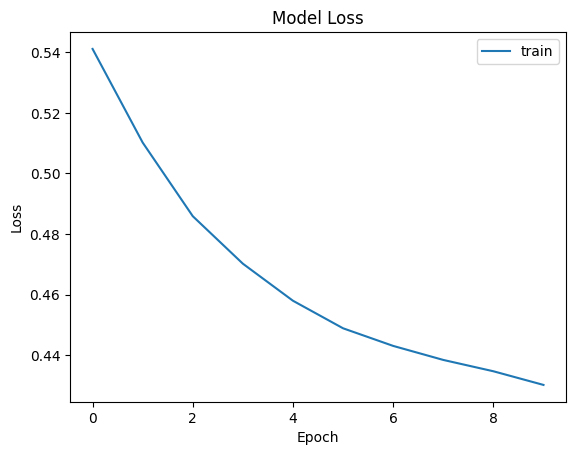

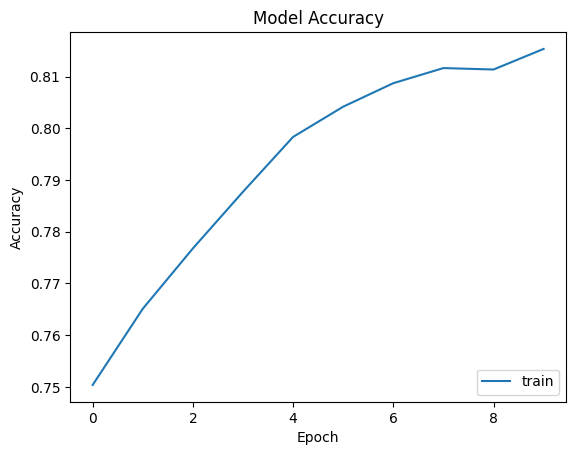

795/795 [==============================] - 7s 8ms/step


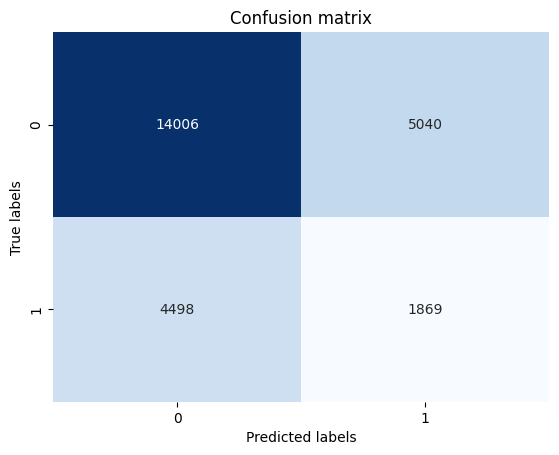

              precision    recall  f1-score   support

           0       0.76      0.74      0.75     19046
           1       0.27      0.29      0.28      6367

    accuracy                           0.62     25413
   macro avg       0.51      0.51      0.51     25413
weighted avg       0.64      0.62      0.63     25413



In [ ]:
plot_history(history2,model2)

In [ ]:
def create_model():
  model2 = Sequential()
  model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(Conv1D(128, 5, activation='relu'))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(LSTM(64, return_sequences=True))
  model2.add(BatchNormalization())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dense(64, activation='relu'))
  model2.add(Dense(32, activation='relu'))
  model2.add(Flatten())
  model2.add(Dense(1, activation='sigmoid'))
  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model2

model2 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model2, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
2499/2499 [==============================] - 40s 14ms/step - loss: 0.5442 - accuracy: 0.7487
Epoch 2/10
2499/2499 [==============================] - 36s 14ms/step - loss: 0.5158 - accuracy: 0.7607
Epoch 3/10
2499/2499 [==============================] - 33s 13ms/step - loss: 0.4919 - accuracy: 0.7751
Epoch 4/10
2499/2499 [==============================] - 34s 13ms/step - loss: 0.4732 - accuracy: 0.7877
Epoch 5/10
2499/2499 [==============================] - 34s 14ms/step - loss: 0.4586 - accuracy: 0.7967
Epoch 6/10
2499/2499 [==============================] - 35s 14ms/step - loss: 0.4485 - accuracy: 0.8035
Epoch 7/10
2499/2499 [==============================] - 37s 15ms/step - loss: 0.4424 - accuracy: 0.8095
Epoch 8/10
2499/2499 [==============================] - 34s 14ms/step - loss: 0.4377 - accuracy: 0.8104
Epoch 9/10
2499/2499 [==============================] - 34s 13ms/step - loss: 0.4330 - accuracy: 0.8143
Epoch 10/10
625/625 [==============================] - 3s 5ms/st

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.79 (+/- 0.02)
Cross-Validation Precision: 0.63 (+/- 0.08)
Cross-Validation Loss: 0.47 (+/- 0.04)
Cross-Validation Recall: 0.43 (+/- 0.12)
Cross-Validation F1 Score: 0.51 (+/- 0.09)


## **FakeBert-DistilBERT**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=5)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=5)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=5)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)

model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 39s 11ms/step - loss: 0.5569 - accuracy: 0.7479
Epoch 2/10
3124/3124 [==============================] - 32s 10ms/step - loss: 0.5424 - accuracy: 0.7488
Epoch 3/10
3124/3124 [==============================] - 30s 9ms/step - loss: 0.5231 - accuracy: 0.7543
Epoch 4/10
3124/3124 [==============================] - 32s 10ms/step - loss: 0.5010 - accuracy: 0.7676
Epoch 5/10
3124/3124 [==============================] - 29s 9ms/step - loss: 0.4813 - accuracy: 0.7803
Epoch 6/10
3124/3124 [==============================] - 30s 9ms/step - loss: 0.4647 - accuracy: 0.7926
Epoch 7/10
3124/3124 [==============================] - 35s 11ms/step - loss: 0.4552 - accuracy: 0.8001
Epoch 8/10
3124/3124 [==============================] - 30s 9ms/step - loss: 0.4474 - accuracy: 0.8065
Epoch 9/10
3124/3124 [==============================] - 31s 10ms/step - loss: 0.4415 - accuracy: 0.8074
Epoch 10/10
3124/3124 [==============================] - 24s 8ms/ste

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 5s - loss: 0.6657 - accuracy: 0.6975 - 5s/epoch - 7ms/step
795/795 [==============================] - 3s 4ms/step
Test Accuracy: 0.6974776983261108
Test F1 Score: 0.16216216216216217
Test Recall: 0.11685252081042877
Precision: 0.2648629405482378


In [ ]:
model3.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_112 (Conv1D)            (None, 768, 128)     512         ['input_8[0][0]']                
                                                                                                  
 conv1d_113 (Conv1D)            (None, 768, 128)     640         ['input_8[0][0]']                
                                                                                                  
 conv1d_114 (Conv1D)            (None, 768, 128)     768         ['input_8[0][0]']                
                                                                                            

795/795 [==============================] - 3s 4ms/step
[[16981  2065]
 [ 5623   744]]


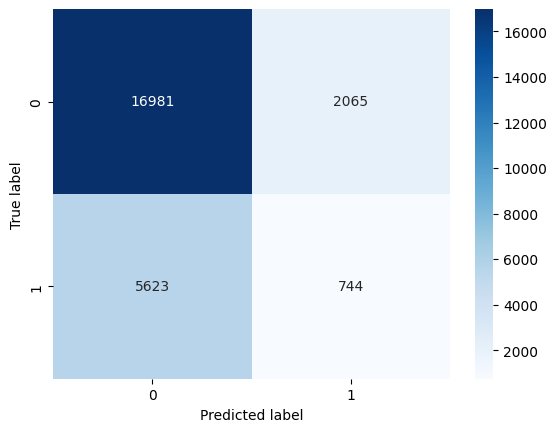

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  inputs = Input(shape=(768, 1))
  conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
  maxpool1 = MaxPooling1D(pool_size=5)(conv1)
  conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
  maxpool2 = MaxPooling1D(pool_size=5)(conv2)
  conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
  maxpool3 = MaxPooling1D(pool_size=5)(conv3)
  concat = Concatenate()([maxpool1, maxpool2, maxpool3])
  conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
  maxpool4 = MaxPooling1D(pool_size=2)(conv4)
  flatten = Flatten()(maxpool4)
  dense1 = Dense(384, activation='relu')(flatten)
  dropout1 = Dropout(0.5)(dense1)
  dense2 = Dense(128, activation='relu')(dropout1)
  dropout2 = Dropout(0.5)(dense2)
  output = Dense(1, activation='sigmoid')(dropout2)
  model3 = Model(inputs=inputs, outputs=output)
  model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model3

model3 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model3, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
2499/2499 [==============================] - 22s 8ms/step - loss: 0.5609 - accuracy: 0.7479
Epoch 2/10
2499/2499 [==============================] - 20s 8ms/step - loss: 0.5437 - accuracy: 0.7479
Epoch 3/10
2499/2499 [==============================] - 19s 8ms/step - loss: 0.5278 - accuracy: 0.7540
Epoch 4/10
2499/2499 [==============================] - 19s 8ms/step - loss: 0.5105 - accuracy: 0.7627
Epoch 5/10
2499/2499 [==============================] - 21s 8ms/step - loss: 0.4912 - accuracy: 0.7743
Epoch 6/10
2499/2499 [==============================] - 19s 8ms/step - loss: 0.4774 - accuracy: 0.7855
Epoch 7/10
2499/2499 [==============================] - 20s 8ms/step - loss: 0.4624 - accuracy: 0.7957
Epoch 8/10
2499/2499 [==============================] - 20s 8ms/step - loss: 0.4506 - accuracy: 0.8044
Epoch 9/10
2499/2499 [==============================] - 20s 8ms/step - loss: 0.4408 - accuracy: 0.8087
Epoch 10/10
625/625 [==============================] - 2s 3ms/step
Epoch 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.81 (+/- 0.01)
Cross-Validation Precision: 0.81 (+/- 0.05)
Cross-Validation Loss: 0.44 (+/- 0.02)
Cross-Validation Recall: 0.34 (+/- 0.06)
Cross-Validation F1 Score: 0.47 (+/- 0.06)


## **CNN Light - DistilBERT**

In [ ]:
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
model4.add(MaxPooling1D(pool_size = 2))
model4.add(Flatten())
model4.add(Dense(units=64, activation='relu'))
model4.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 15s 4ms/step - loss: 0.5422 - accuracy: 0.7479
Epoch 2/10
3124/3124 [==============================] - 14s 4ms/step - loss: 0.5194 - accuracy: 0.7536
Epoch 3/10
3124/3124 [==============================] - 14s 4ms/step - loss: 0.5038 - accuracy: 0.7622
Epoch 4/10
3124/3124 [==============================] - 13s 4ms/step - loss: 0.4876 - accuracy: 0.7745
Epoch 5/10
3124/3124 [==============================] - 13s 4ms/step - loss: 0.4736 - accuracy: 0.7839
Epoch 6/10
3124/3124 [==============================] - 14s 4ms/step - loss: 0.4657 - accuracy: 0.7894
Epoch 7/10
3124/3124 [==============================] - 13s 4ms/step - loss: 0.4557 - accuracy: 0.7979
Epoch 8/10
3124/3124 [==============================] - 14s 4ms/step - loss: 0.4480 - accuracy: 0.8025
Epoch 9/10
3124/3124 [==============================] - 14s 4ms/step - loss: 0.4432 - accuracy: 0.8077
Epoch 10/10
3124/3124 [==============================] - 14s 4ms/step - l

In [ ]:
test_loss, test_acc = model4.evaluate(test_embeddings, test_labels)

y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')


f1 = f1_score(test_labels,y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 1s 2ms/step
Test Accuracy: 0.6123244166374207
Test F1 Score: 0.2664184661206255
Test Recall: 0.28098005340034554
Precision: 0.2532918023502761


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model4.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_69 (Conv1D)          (None, 766, 32)           128       
                                                                 
 max_pooling1d_69 (MaxPoolin  (None, 383, 32)          0         
 g1D)                                                            
                                                                 
 flatten_23 (Flatten)        (None, 12256)             0         
                                                                 
 dense_75 (Dense)            (None, 64)                784448    
                                                                 
 dense_76 (Dense)            (None, 1)                 65        
                                                                 
Total params: 784,641
Trainable params: 784,641
Non-trainable params: 0
_______________________________________________

795/795 [==============================] - 1s 2ms/step
[[13772  5274]
 [ 4578  1789]]


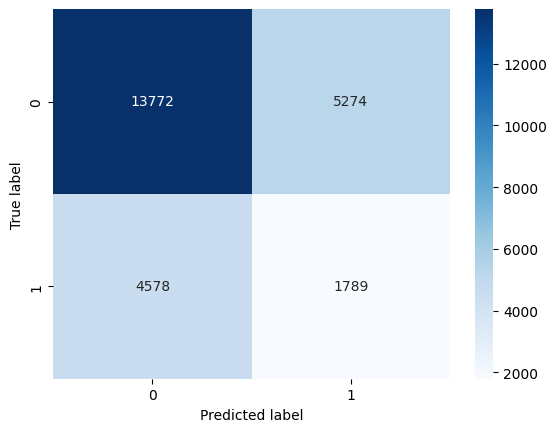

In [ ]:
y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

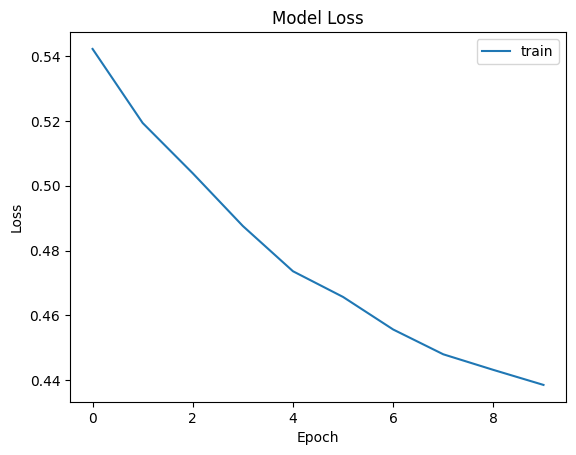

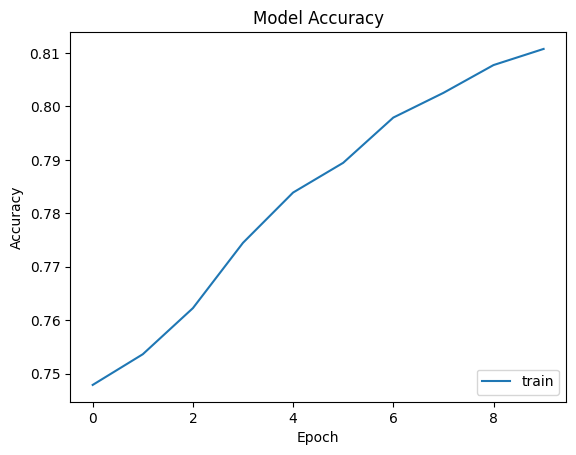

795/795 [==============================] - 1s 2ms/step


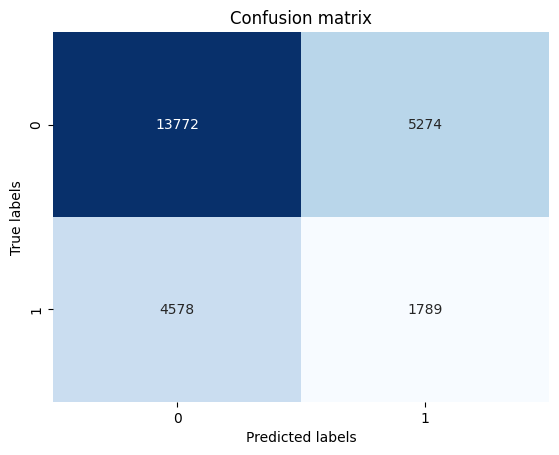

              precision    recall  f1-score   support

           0       0.75      0.72      0.74     19046
           1       0.25      0.28      0.27      6367

    accuracy                           0.61     25413
   macro avg       0.50      0.50      0.50     25413
weighted avg       0.63      0.61      0.62     25413



In [ ]:
plot_history(history4,model4)

In [ ]:
def create_model():
  model4 = Sequential()
  model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
  model4.add(MaxPooling1D(pool_size = 2))
  model4.add(Flatten())
  model4.add(Dense(units=64, activation='relu'))
  model4.add(Dense(units=1, activation='sigmoid'))
  model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model4

model4 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model4, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
2499/2499 [==============================] - 12s 4ms/step - loss: 0.5429 - accuracy: 0.7487
Epoch 2/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.5210 - accuracy: 0.7547
Epoch 3/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.5046 - accuracy: 0.7647
Epoch 4/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.4903 - accuracy: 0.7739
Epoch 5/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.4766 - accuracy: 0.7826
Epoch 6/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.4668 - accuracy: 0.7911
Epoch 7/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.4589 - accuracy: 0.7960
Epoch 8/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.4517 - accuracy: 0.8012
Epoch 9/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.4463 - accuracy: 0.8043
Epoch 10/10
625/625 [==============================] - 1s 2ms/step
Epoch 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.81 (+/- 0.01)
Cross-Validation Precision: 0.71 (+/- 0.08)
Cross-Validation Loss: 0.44 (+/- 0.02)
Cross-Validation Recall: 0.42 (+/- 0.07)
Cross-Validation F1 Score: 0.53 (+/- 0.04)


## **Bidirectional L2 LSTM-DistilBERT**

In [ ]:
model5 = Sequential()
model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(128, 5, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Bidirectional(LSTM(64, return_sequences=True)))
model5.add(BatchNormalization())
model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Flatten())
model5.add(Dense(1, activation='sigmoid'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 75s 22ms/step - loss: 0.6159 - accuracy: 0.7477
Epoch 2/10
3124/3124 [==============================] - 64s 21ms/step - loss: 0.5328 - accuracy: 0.7538
Epoch 3/10
3124/3124 [==============================] - 67s 21ms/step - loss: 0.5135 - accuracy: 0.7638
Epoch 4/10
3124/3124 [==============================] - 66s 21ms/step - loss: 0.4948 - accuracy: 0.7736
Epoch 5/10
3124/3124 [==============================] - 64s 20ms/step - loss: 0.4798 - accuracy: 0.7848
Epoch 6/10
3124/3124 [==============================] - 67s 21ms/step - loss: 0.4683 - accuracy: 0.7930
Epoch 7/10
3124/3124 [==============================] - 64s 20ms/step - loss: 0.4612 - accuracy: 0.7981
Epoch 8/10
3124/3124 [==============================] - 65s 21ms/step - loss: 0.4519 - accuracy: 0.8041
Epoch 9/10
3124/3124 [==============================] - 66s 21ms/step - loss: 0.4459 - accuracy: 0.8076
Epoch 10/10
3124/3124 [==============================] - 65s 21m

In [ ]:
test_loss, test_acc = model5.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model5.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 9s - loss: 0.7528 - accuracy: 0.6226 - 9s/epoch - 12ms/step
795/795 [==============================] - 9s 11ms/step
Test Accuracy: 0.6226341128349304
Test F1 Score: 0.2684973302822273
Test Recall: 0.2764253180461756
Precision: 0.26101141924959215


In [ ]:
model5.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_75 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_75 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_76 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_76 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirectiona  (None, 189, 128)         98816     
 l)                                                              
                                                     

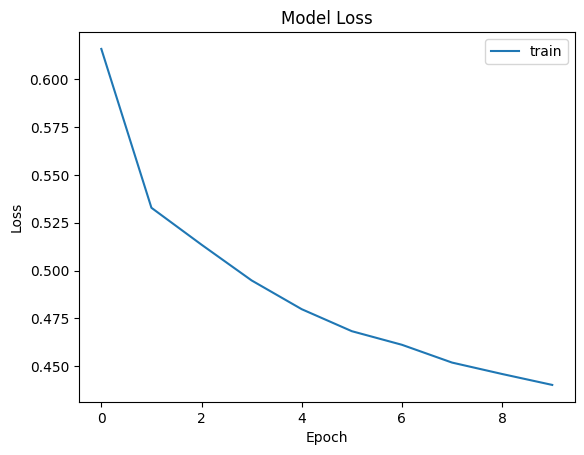

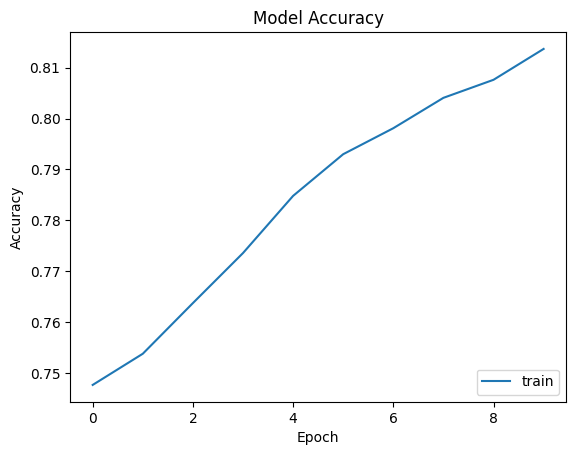

795/795 [==============================] - 8s 10ms/step


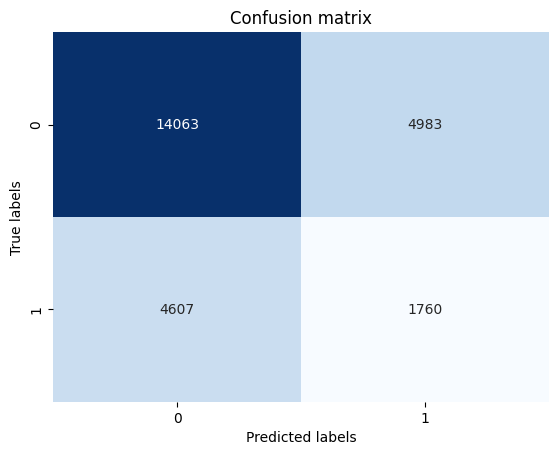

              precision    recall  f1-score   support

           0       0.75      0.74      0.75     19046
           1       0.26      0.28      0.27      6367

    accuracy                           0.62     25413
   macro avg       0.51      0.51      0.51     25413
weighted avg       0.63      0.62      0.63     25413



In [ ]:
plot_history(history5,model5)

In [ ]:
def create_model():
  model5 = Sequential()
  model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Conv1D(128, 5, activation='relu'))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Bidirectional(LSTM(64, return_sequences=True)))
  model5.add(BatchNormalization())
  model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Flatten())
  model5.add(Dense(1, activation='sigmoid'))
  model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model5

model5 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model5, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
2499/2499 [==============================] - 59s 21ms/step - loss: 0.6291 - accuracy: 0.7484
Epoch 2/10
2499/2499 [==============================] - 51s 21ms/step - loss: 0.5419 - accuracy: 0.7517
Epoch 3/10
2499/2499 [==============================] - 51s 21ms/step - loss: 0.5294 - accuracy: 0.7556
Epoch 4/10
2499/2499 [==============================] - 53s 21ms/step - loss: 0.5154 - accuracy: 0.7641
Epoch 5/10
2499/2499 [==============================] - 52s 21ms/step - loss: 0.5018 - accuracy: 0.7721
Epoch 6/10
2499/2499 [==============================] - 50s 20ms/step - loss: 0.4905 - accuracy: 0.7796
Epoch 7/10
2499/2499 [==============================] - 52s 21ms/step - loss: 0.4805 - accuracy: 0.7846
Epoch 8/10
2499/2499 [==============================] - 51s 20ms/step - loss: 0.4722 - accuracy: 0.7890
Epoch 9/10
2499/2499 [==============================] - 50s 20ms/step - loss: 0.4626 - accuracy: 0.7957
Epoch 10/10
625/625 [==============================] - 5s 7ms/st

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.79 (+/- 0.03)
Cross-Validation Precision: 0.68 (+/- 0.06)
Cross-Validation Loss: 0.48 (+/- 0.04)
Cross-Validation Recall: 0.31 (+/- 0.13)
Cross-Validation F1 Score: 0.43 (+/- 0.14)


## **L2 CNN-DistilBERT**

In [ ]:
# build the model
model6 = Sequential()
model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Flatten())
model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(1, activation='sigmoid'))

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 22s 6ms/step - loss: 0.6124 - accuracy: 0.7480
Epoch 2/10
3124/3124 [==============================] - 19s 6ms/step - loss: 0.5545 - accuracy: 0.7481
Epoch 3/10
3124/3124 [==============================] - 20s 6ms/step - loss: 0.5441 - accuracy: 0.7481
Epoch 4/10
3124/3124 [==============================] - 18s 6ms/step - loss: 0.5352 - accuracy: 0.7481
Epoch 5/10
3124/3124 [==============================] - 18s 6ms/step - loss: 0.5263 - accuracy: 0.7481
Epoch 6/10
3124/3124 [==============================] - 20s 6ms/step - loss: 0.5191 - accuracy: 0.7481
Epoch 7/10
3124/3124 [==============================] - 19s 6ms/step - loss: 0.5119 - accuracy: 0.7481
Epoch 8/10
3124/3124 [==============================] - 19s 6ms/step - loss: 0.5067 - accuracy: 0.7501
Epoch 9/10
3124/3124 [==============================] - 21s 7ms/step - loss: 0.5011 - accuracy: 0.7603
Epoch 10/10
3124/3124 [==============================] - 18s 6ms/step - l

In [ ]:
test_loss, test_acc = model6.evaluate(test_embeddings, test_labels)

y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 2s 3ms/step
Test Accuracy: 0.6820918321609497
Test F1 Score: 0.1850095833753657
Test Recall: 0.14402387309564943
Precision: 0.2586012408347434


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model6.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_105 (Conv1D)         (None, 764, 128)          768       
                                                                 
 max_pooling1d_105 (MaxPooli  (None, 152, 128)         0         
 ng1D)                                                           
                                                                 
 conv1d_106 (Conv1D)         (None, 148, 128)          82048     
                                                                 
 max_pooling1d_106 (MaxPooli  (None, 29, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_107 (Conv1D)         (None, 25, 128)           82048     
                                                                 
 max_pooling1d_107 (MaxPooli  (None, 5, 128)         

795/795 [==============================] - 2s 2ms/step
[[16417  2629]
 [ 5450   917]]


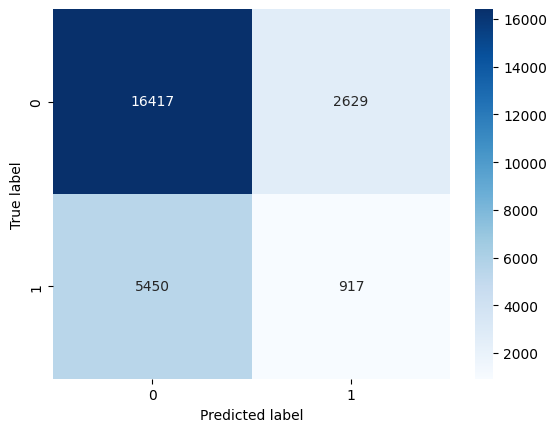

In [ ]:
y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

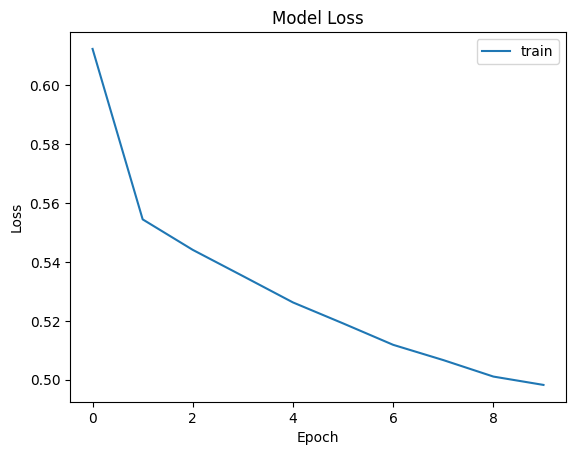

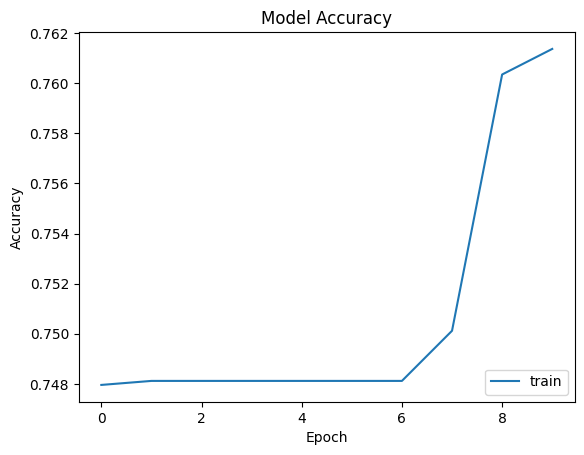

795/795 [==============================] - 2s 3ms/step


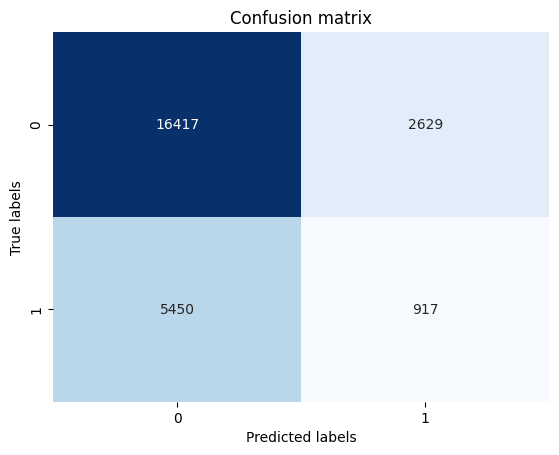

              precision    recall  f1-score   support

           0       0.75      0.86      0.80     19046
           1       0.26      0.14      0.19      6367

    accuracy                           0.68     25413
   macro avg       0.50      0.50      0.49     25413
weighted avg       0.63      0.68      0.65     25413



In [ ]:
plot_history(history6,model6)

In [ ]:
def create_model():
  model6 = Sequential()
  model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Flatten())
  model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(1, activation='sigmoid'))
  model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model6

model6 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model6, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
2499/2499 [==============================] - 18s 6ms/step - loss: 0.6208 - accuracy: 0.7479
Epoch 2/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.5534 - accuracy: 0.7481
Epoch 3/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5450 - accuracy: 0.7481
Epoch 4/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.5352 - accuracy: 0.7481
Epoch 5/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5264 - accuracy: 0.7481
Epoch 6/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5184 - accuracy: 0.7481
Epoch 7/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5112 - accuracy: 0.7481
Epoch 8/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.5040 - accuracy: 0.7529
Epoch 9/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.4991 - accuracy: 0.7635
Epoch 10/10
625/625 [==============================] - 2s 3ms/step
Epoch 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


625/625 [==============================] - 2s 3ms/step
Epoch 1/10
2499/2499 [==============================] - 19s 6ms/step - loss: 0.6239 - accuracy: 0.7472
Epoch 2/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.5537 - accuracy: 0.7481
Epoch 3/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5451 - accuracy: 0.7481
Epoch 4/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5366 - accuracy: 0.7481
Epoch 5/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5297 - accuracy: 0.7481
Epoch 6/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5233 - accuracy: 0.7481
Epoch 7/10
2499/2499 [==============================] - 16s 7ms/step - loss: 0.5157 - accuracy: 0.7481
Epoch 8/10
2499/2499 [==============================] - 16s 7ms/step - loss: 0.5124 - accuracy: 0.7481
Epoch 9/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5059 - accuracy: 0.7481
Epoch 10/10
 50/62

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


625/625 [==============================] - 1s 2ms/step
Epoch 1/10
2499/2499 [==============================] - 20s 7ms/step - loss: 0.6246 - accuracy: 0.7477
Epoch 2/10
2499/2499 [==============================] - 16s 7ms/step - loss: 0.5548 - accuracy: 0.7481
Epoch 3/10
2499/2499 [==============================] - 17s 7ms/step - loss: 0.5484 - accuracy: 0.7481
Epoch 4/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5413 - accuracy: 0.7481
Epoch 5/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5319 - accuracy: 0.7481
Epoch 6/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5247 - accuracy: 0.7481
Epoch 7/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5164 - accuracy: 0.7481
Epoch 8/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.5102 - accuracy: 0.7481
Epoch 9/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.5045 - accuracy: 0.7481
Epoch 10/10
625/62

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.76 (+/- 0.02)
Cross-Validation Precision: 0.34 (+/- 0.56)
Cross-Validation Loss: 0.49 (+/- 0.01)
Cross-Validation Recall: 0.15 (+/- 0.28)
Cross-Validation F1 Score: 0.21 (+/- 0.36)


# Max Worth

## **CNN-DistilBERT**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_max_bin.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_max_bin.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_max_bin.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_max_bin.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 30s 6ms/step - loss: 0.5601 - accuracy: 0.7478
Epoch 2/10
3124/3124 [==============================] - 16s 5ms/step - loss: 0.5384 - accuracy: 0.7493
Epoch 3/10
3124/3124 [==============================] - 18s 6ms/step - loss: 0.5151 - accuracy: 0.7626
Epoch 4/10
3124/3124 [==============================] - 16s 5ms/step - loss: 0.4994 - accuracy: 0.7732
Epoch 5/10
3124/3124 [==============================] - 16s 5ms/step - loss: 0.4859 - accuracy: 0.7835
Epoch 6/10
3124/3124 [==============================] - 16s 5ms/step - loss: 0.4754 - accuracy: 0.7895
Epoch 7/10
3124/3124 [==============================] - 16s 5ms/step - loss: 0.4651 - accuracy: 0.7976
Epoch 8/10
3124/3124 [==============================] - 16s 5ms/step - loss: 0.4593 - accuracy: 0.8016
Epoch 9/10
3124/3124 [==============================] - 16s 5ms/step - loss: 0.4533 - accuracy: 0.8036
Epoch 10/10
3124/3124 [==============================] - 17s 5ms/step - l

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 2s 3ms/step
Test Accuracy: 0.6732380986213684
Test F1 Score: 0.18332022029897718
Test Recall: 0.1463797706926339
Precision: 0.24519863193896344


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(test_embeddings)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(test_labels, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()

    # Print the classification report
    print(classification_report(test_labels, y_pred))

In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 128)           0

795/795 [==============================] - 2s 2ms/step
[[16177  2869]
 [ 5435   932]]


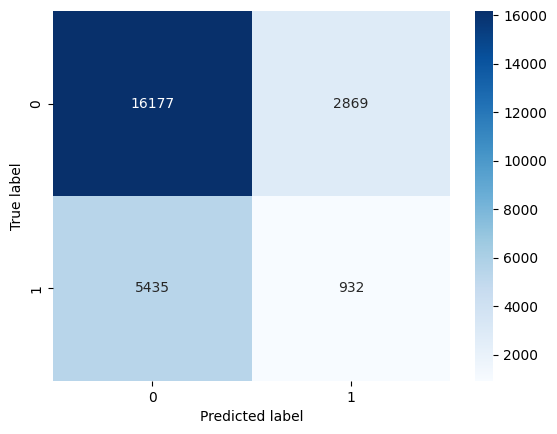

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

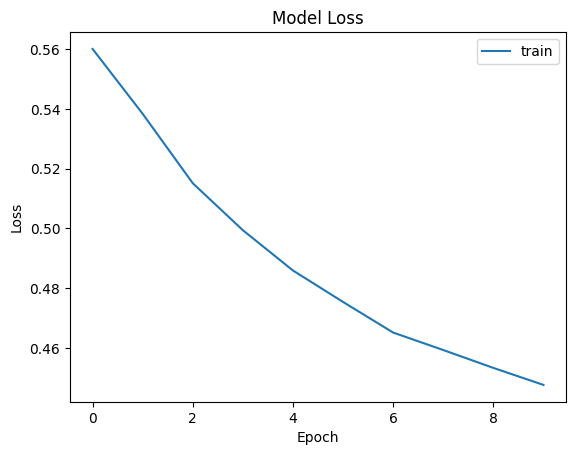

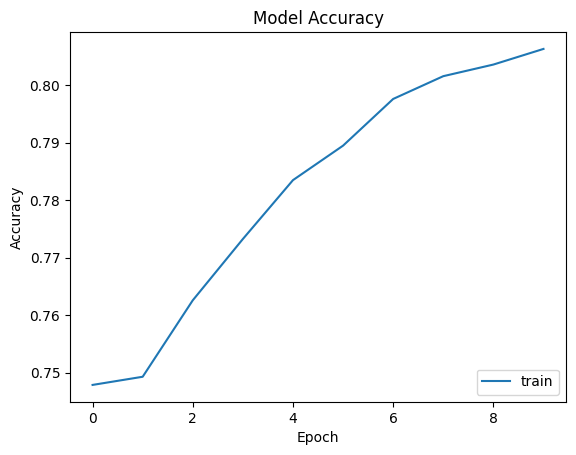

795/795 [==============================] - 4s 4ms/step


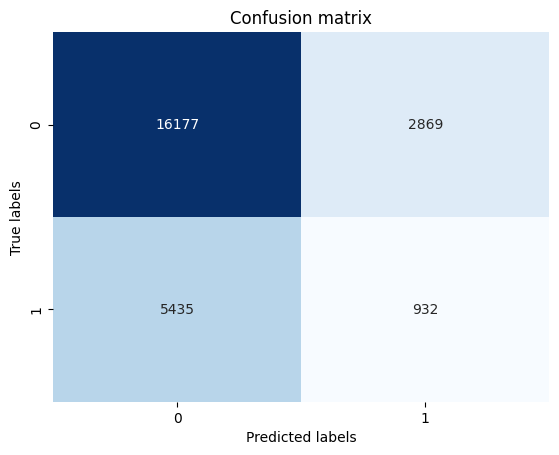

              precision    recall  f1-score   support

           0       0.75      0.85      0.80     19046
           1       0.25      0.15      0.18      6367

    accuracy                           0.67     25413
   macro avg       0.50      0.50      0.49     25413
weighted avg       0.62      0.67      0.64     25413



In [ ]:
plot_history(history1,model)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model1 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model1, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
2499/2499 [==============================] - 16s 5ms/step - loss: 0.5621 - accuracy: 0.7477
Epoch 2/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.5465 - accuracy: 0.7482
Epoch 3/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.5310 - accuracy: 0.7493
Epoch 4/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.5185 - accuracy: 0.7535
Epoch 5/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.5051 - accuracy: 0.7616
Epoch 6/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.4963 - accuracy: 0.7670
Epoch 7/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.4897 - accuracy: 0.7745
Epoch 8/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.4814 - accuracy: 0.7829
Epoch 9/10
2499/2499 [==============================] - 15s 6ms/step - loss: 0.4736 - accuracy: 0.7881
Epoch 10/10
625/625 [==============================] - 1s 2ms/step
Epoch 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.80 (+/- 0.01)
Cross-Validation Precision: 0.70 (+/- 0.08)
Cross-Validation Loss: 0.46 (+/- 0.02)
Cross-Validation Recall: 0.36 (+/- 0.09)
Cross-Validation F1 Score: 0.47 (+/- 0.06)


## **LSTM-DistilBERT**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(64, return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 45s 12ms/step - loss: 0.5434 - accuracy: 0.7504
Epoch 2/10
3124/3124 [==============================] - 38s 12ms/step - loss: 0.5128 - accuracy: 0.7619
Epoch 3/10
3124/3124 [==============================] - 37s 12ms/step - loss: 0.4868 - accuracy: 0.7779
Epoch 4/10
3124/3124 [==============================] - 38s 12ms/step - loss: 0.4687 - accuracy: 0.7892
Epoch 5/10
3124/3124 [==============================] - 37s 12ms/step - loss: 0.4560 - accuracy: 0.7975
Epoch 6/10
3124/3124 [==============================] - 38s 12ms/step - loss: 0.4478 - accuracy: 0.8059
Epoch 7/10
3124/3124 [==============================] - 39s 12ms/step - loss: 0.4382 - accuracy: 0.8093
Epoch 8/10
3124/3124 [==============================] - 41s 13ms/step - loss: 0.4342 - accuracy: 0.8121
Epoch 9/10
3124/3124 [==============================] - 40s 13ms/step - loss: 0.4292 - accuracy: 0.8157
Epoch 10/10
3124/3124 [==============================] - 39s 12m

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 6s - loss: 0.7094 - accuracy: 0.6378 - 6s/epoch - 7ms/step
795/795 [==============================] - 6s 7ms/step
Test Accuracy: 0.6378231644630432
Test F1 Score: 0.22105619498984427
Test Recall: 0.20512015077744622
Precision: 0.23967700495503763


In [ ]:
model2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_42 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_42 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_43 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_43 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 189, 64)           49408     
                                                                 
 batch_normalization (BatchN  (None, 189, 64)        

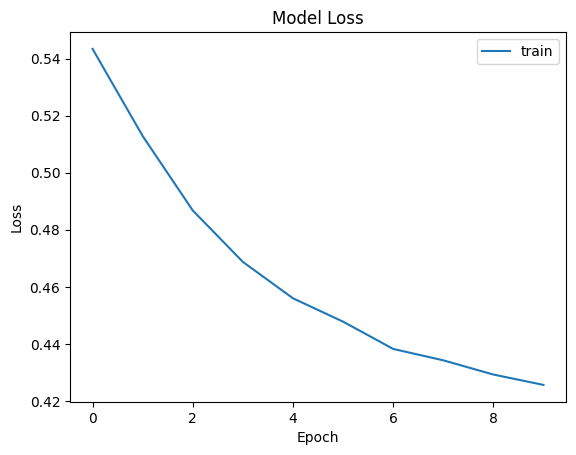

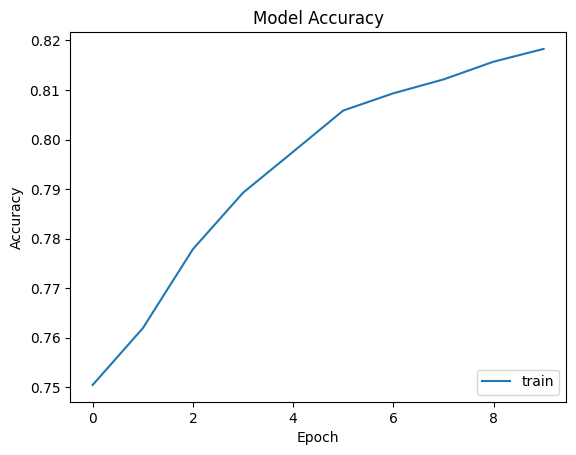

795/795 [==============================] - 6s 8ms/step


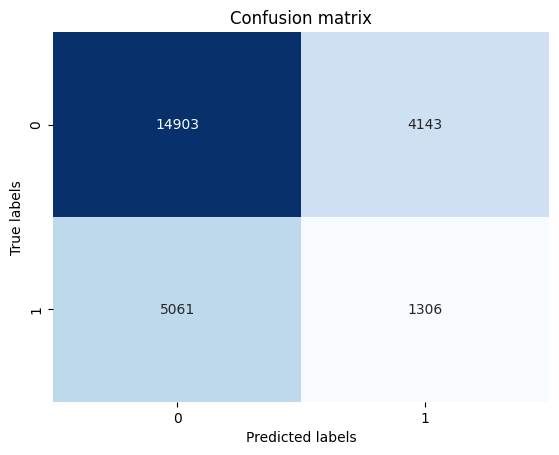

              precision    recall  f1-score   support

           0       0.75      0.78      0.76     19046
           1       0.24      0.21      0.22      6367

    accuracy                           0.64     25413
   macro avg       0.49      0.49      0.49     25413
weighted avg       0.62      0.64      0.63     25413



In [ ]:
plot_history(history2,model2)

In [ ]:
def create_model():
  model2 = Sequential()
  model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(Conv1D(128, 5, activation='relu'))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(LSTM(64, return_sequences=True))
  model2.add(BatchNormalization())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dense(64, activation='relu'))
  model2.add(Dense(32, activation='relu'))
  model2.add(Flatten())
  model2.add(Dense(1, activation='sigmoid'))
  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model2

model2 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model2, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
2499/2499 [==============================] - 87s 24ms/step - loss: 0.5470 - accuracy: 0.7501
Epoch 2/10
2499/2499 [==============================] - 49s 20ms/step - loss: 0.5187 - accuracy: 0.7609
Epoch 3/10
2499/2499 [==============================] - 32s 13ms/step - loss: 0.4940 - accuracy: 0.7727
Epoch 4/10
2499/2499 [==============================] - 34s 14ms/step - loss: 0.4763 - accuracy: 0.7843
Epoch 5/10
2499/2499 [==============================] - 33s 13ms/step - loss: 0.4618 - accuracy: 0.7920
Epoch 6/10
2499/2499 [==============================] - 31s 12ms/step - loss: 0.4523 - accuracy: 0.8018
Epoch 7/10
2499/2499 [==============================] - 31s 13ms/step - loss: 0.4423 - accuracy: 0.8085
Epoch 8/10
2499/2499 [==============================] - 32s 13ms/step - loss: 0.4394 - accuracy: 0.8104
Epoch 9/10
2499/2499 [==============================] - 33s 13ms/step - loss: 0.4343 - accuracy: 0.8149
Epoch 10/10
625/625 [==============================] - 3s 5ms/st

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.80 (+/- 0.02)
Cross-Validation Precision: 0.70 (+/- 0.15)
Cross-Validation Loss: 0.47 (+/- 0.03)
Cross-Validation Recall: 0.36 (+/- 0.07)
Cross-Validation F1 Score: 0.47 (+/- 0.05)


## **FakeBert-DistilBERT**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=5)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=5)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=5)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)
model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 26s 8ms/step - loss: 0.5565 - accuracy: 0.7475
Epoch 2/10
3124/3124 [==============================] - 23s 7ms/step - loss: 0.5349 - accuracy: 0.7483
Epoch 3/10
3124/3124 [==============================] - 23s 7ms/step - loss: 0.5164 - accuracy: 0.7596
Epoch 4/10
3124/3124 [==============================] - 23s 7ms/step - loss: 0.4968 - accuracy: 0.7707
Epoch 5/10
3124/3124 [==============================] - 23s 7ms/step - loss: 0.4789 - accuracy: 0.7842
Epoch 6/10
3124/3124 [==============================] - 23s 7ms/step - loss: 0.4649 - accuracy: 0.7950
Epoch 7/10
3124/3124 [==============================] - 24s 8ms/step - loss: 0.4546 - accuracy: 0.7996
Epoch 8/10
3124/3124 [==============================] - 23s 7ms/step - loss: 0.4464 - accuracy: 0.8056
Epoch 9/10
3124/3124 [==============================] - 22s 7ms/step - loss: 0.4405 - accuracy: 0.8083
Epoch 10/10
3124/3124 [==============================] - 23s 7ms/step - l

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 4s - loss: 0.6687 - accuracy: 0.6991 - 4s/epoch - 5ms/step
795/795 [==============================] - 3s 4ms/step
Test Accuracy: 0.6990516781806946
Test F1 Score: 0.16797214969538726
Test Recall: 0.12125019632479975
Precision: 0.2732743362831858


In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 768, 128)     512         ['input_1[0][0]']                
                                                                                                  
 conv1d_11 (Conv1D)             (None, 768, 128)     640         ['input_1[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 768, 128)     768         ['input_1[0][0]']                
                                                                                              

795/795 [==============================] - 3s 4ms/step
[[16993  2053]
 [ 5595   772]]


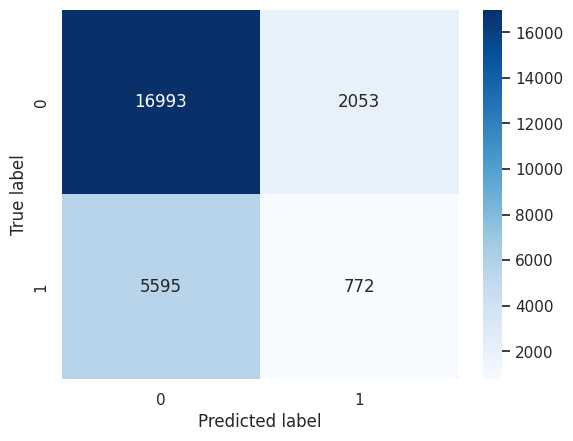

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  inputs = Input(shape=(768, 1))
  conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
  maxpool1 = MaxPooling1D(pool_size=5)(conv1)
  conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
  maxpool2 = MaxPooling1D(pool_size=5)(conv2)
  conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
  maxpool3 = MaxPooling1D(pool_size=5)(conv3)
  concat = Concatenate()([maxpool1, maxpool2, maxpool3])
  conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
  maxpool4 = MaxPooling1D(pool_size=2)(conv4)
  flatten = Flatten()(maxpool4)
  dense1 = Dense(384, activation='relu')(flatten)
  dropout1 = Dropout(0.5)(dense1)
  dense2 = Dense(128, activation='relu')(dropout1)
  dropout2 = Dropout(0.5)(dense2)
  output = Dense(1, activation='sigmoid')(dropout2)
  model3 = Model(inputs=inputs, outputs=output)
  model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model3

model3 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model3, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
2499/2499 [==============================] - 34s 8ms/step - loss: 0.5605 - accuracy: 0.7480
Epoch 2/10
2499/2499 [==============================] - 20s 8ms/step - loss: 0.5448 - accuracy: 0.7488
Epoch 3/10
2499/2499 [==============================] - 20s 8ms/step - loss: 0.5338 - accuracy: 0.7549
Epoch 4/10
2499/2499 [==============================] - 19s 8ms/step - loss: 0.5233 - accuracy: 0.7598
Epoch 5/10
2499/2499 [==============================] - 20s 8ms/step - loss: 0.5120 - accuracy: 0.7655
Epoch 6/10
2499/2499 [==============================] - 20s 8ms/step - loss: 0.5013 - accuracy: 0.7712
Epoch 7/10
2499/2499 [==============================] - 20s 8ms/step - loss: 0.4918 - accuracy: 0.7761
Epoch 8/10
2499/2499 [==============================] - 19s 8ms/step - loss: 0.4831 - accuracy: 0.7822
Epoch 9/10
2499/2499 [==============================] - 20s 8ms/step - loss: 0.4757 - accuracy: 0.7860
Epoch 10/10
625/625 [==============================] - 2s 3ms/step
Epoch 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.80 (+/- 0.03)
Cross-Validation Precision: 0.78 (+/- 0.07)
Cross-Validation Loss: 0.45 (+/- 0.04)
Cross-Validation Recall: 0.29 (+/- 0.16)
Cross-Validation F1 Score: 0.42 (+/- 0.18)


## **CNN Light - DistilBERT**

In [ ]:
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
model4.add(MaxPooling1D(pool_size = 2))
model4.add(Flatten())
model4.add(Dense(units=64, activation='relu'))
model4.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 13s 3ms/step - loss: 0.5402 - accuracy: 0.7488
Epoch 2/10
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5168 - accuracy: 0.7568
Epoch 3/10
3124/3124 [==============================] - 12s 4ms/step - loss: 0.4973 - accuracy: 0.7684
Epoch 4/10
3124/3124 [==============================] - 12s 4ms/step - loss: 0.4830 - accuracy: 0.7780
Epoch 5/10
3124/3124 [==============================] - 12s 4ms/step - loss: 0.4690 - accuracy: 0.7883
Epoch 6/10
3124/3124 [==============================] - 11s 3ms/step - loss: 0.4591 - accuracy: 0.7959
Epoch 7/10
3124/3124 [==============================] - 12s 4ms/step - loss: 0.4508 - accuracy: 0.8003
Epoch 8/10
3124/3124 [==============================] - 12s 4ms/step - loss: 0.4427 - accuracy: 0.8077
Epoch 9/10
3124/3124 [==============================] - 14s 4ms/step - loss: 0.4374 - accuracy: 0.8120
Epoch 10/10
3124/3124 [==============================] - 12s 4ms/step - l

In [ ]:
test_loss, test_acc = model4.evaluate(test_embeddings, test_labels)

y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')


f1 = f1_score(test_labels,y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 2s 2ms/step
Test Accuracy: 0.5521583557128906
Test F1 Score: 0.3229222440359331
Test Recall: 0.4262604052143867
Precision: 0.2599118942731278


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 766, 32)           128       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 383, 32)          0         
 g1D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 12256)             0         
                                                                 
 dense_18 (Dense)            (None, 64)                784448    
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 784,641
Trainable params: 784,641
Non-trainable params: 0
________________________________________________

795/795 [==============================] - 1s 2ms/step
[[11318  7728]
 [ 3653  2714]]


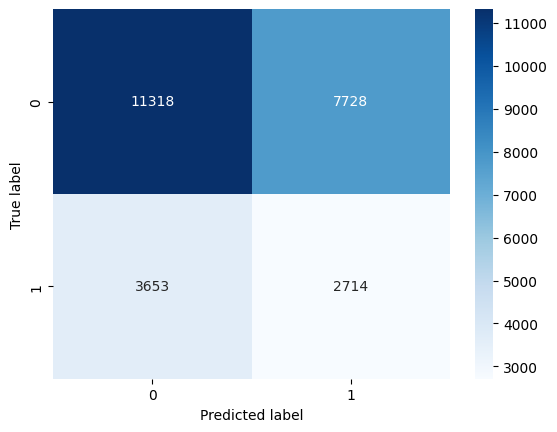

In [ ]:
y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

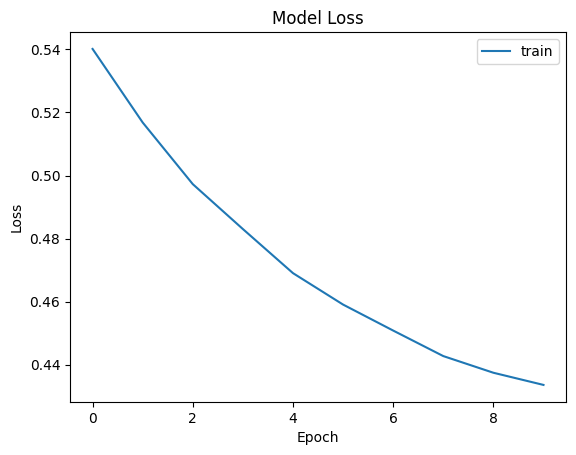

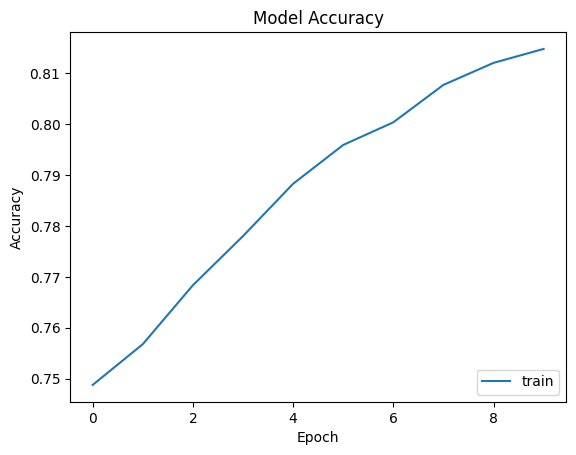

795/795 [==============================] - 1s 2ms/step


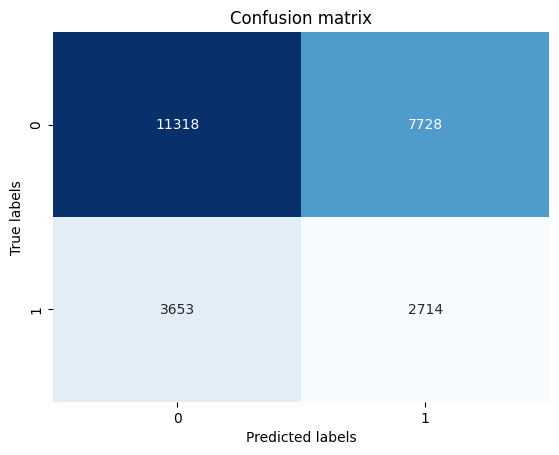

              precision    recall  f1-score   support

           0       0.76      0.59      0.67     19046
           1       0.26      0.43      0.32      6367

    accuracy                           0.55     25413
   macro avg       0.51      0.51      0.49     25413
weighted avg       0.63      0.55      0.58     25413



In [ ]:
plot_history(history4,model4)

In [ ]:
def create_model():
  model4 = Sequential()
  model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
  model4.add(MaxPooling1D(pool_size = 2))
  model4.add(Flatten())
  model4.add(Dense(units=64, activation='relu'))
  model4.add(Dense(units=1, activation='sigmoid'))
  model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model4

model4 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model4, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
2499/2499 [==============================] - 11s 4ms/step - loss: 0.5427 - accuracy: 0.7480
Epoch 2/10
2499/2499 [==============================] - 9s 3ms/step - loss: 0.5244 - accuracy: 0.7526
Epoch 3/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.5089 - accuracy: 0.7589
Epoch 4/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.4974 - accuracy: 0.7671
Epoch 5/10
2499/2499 [==============================] - 9s 4ms/step - loss: 0.4890 - accuracy: 0.7747
Epoch 6/10
2499/2499 [==============================] - 9s 4ms/step - loss: 0.4790 - accuracy: 0.7795
Epoch 7/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.4705 - accuracy: 0.7878
Epoch 8/10
2499/2499 [==============================] - 8s 3ms/step - loss: 0.4638 - accuracy: 0.7909
Epoch 9/10
2499/2499 [==============================] - 10s 4ms/step - loss: 0.4580 - accuracy: 0.7958
Epoch 10/10
625/625 [==============================] - 1s 1ms/step
Epoch 1/10

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.81 (+/- 0.01)
Cross-Validation Precision: 0.74 (+/- 0.05)
Cross-Validation Loss: 0.45 (+/- 0.01)
Cross-Validation Recall: 0.35 (+/- 0.07)
Cross-Validation F1 Score: 0.48 (+/- 0.06)


## **Bidirectional L2 LSTM-DistilBERT**

In [ ]:
model5 = Sequential()
model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(128, 5, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Bidirectional(LSTM(64, return_sequences=True)))
model5.add(BatchNormalization())
model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Flatten())
model5.add(Dense(1, activation='sigmoid'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 71s 20ms/step - loss: 0.6239 - accuracy: 0.7477
Epoch 2/10
3124/3124 [==============================] - 65s 21ms/step - loss: 0.5382 - accuracy: 0.7527
Epoch 3/10
3124/3124 [==============================] - 62s 20ms/step - loss: 0.5181 - accuracy: 0.7641
Epoch 4/10
3124/3124 [==============================] - 62s 20ms/step - loss: 0.4995 - accuracy: 0.7754
Epoch 5/10
3124/3124 [==============================] - 64s 21ms/step - loss: 0.4868 - accuracy: 0.7830
Epoch 6/10
3124/3124 [==============================] - 65s 21ms/step - loss: 0.4745 - accuracy: 0.7903
Epoch 7/10
3124/3124 [==============================] - 65s 21ms/step - loss: 0.4645 - accuracy: 0.7971
Epoch 8/10
3124/3124 [==============================] - 63s 20ms/step - loss: 0.4598 - accuracy: 0.7996
Epoch 9/10
3124/3124 [==============================] - 61s 19ms/step - loss: 0.4532 - accuracy: 0.8056
Epoch 10/10
3124/3124 [==============================] - 62s 20m

In [ ]:
test_loss, test_acc = model5.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model5.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 9s - loss: 0.6577 - accuracy: 0.6841 - 9s/epoch - 11ms/step
795/795 [==============================] - 9s 10ms/step
Test Accuracy: 0.6840593218803406
Test F1 Score: 0.1716702775198597
Test Recall: 0.13067378671273755
Precision: 0.25015033072760073


In [ ]:
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirectiona  (None, 189, 128)         98816     
 l)                                                              
                                                        

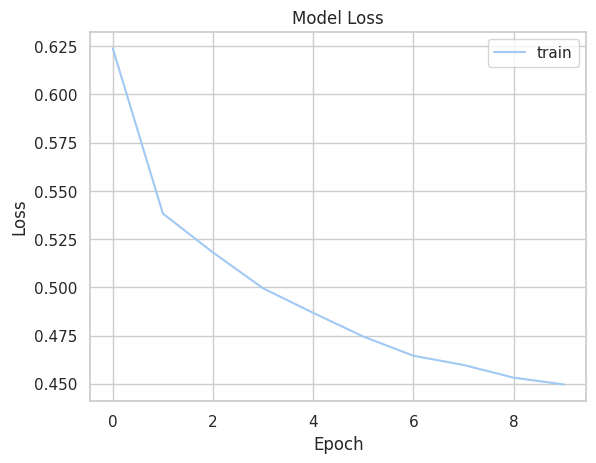

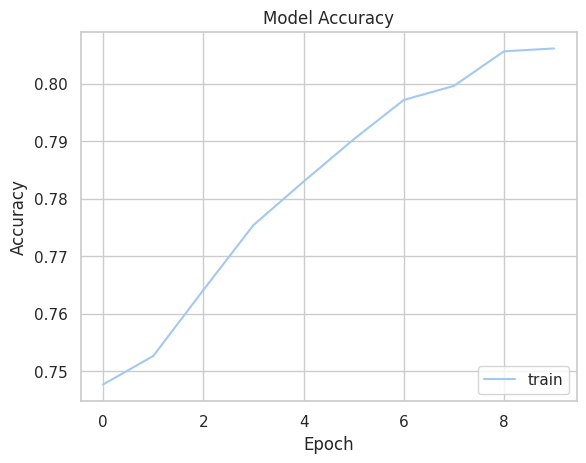

795/795 [==============================] - 9s 11ms/step


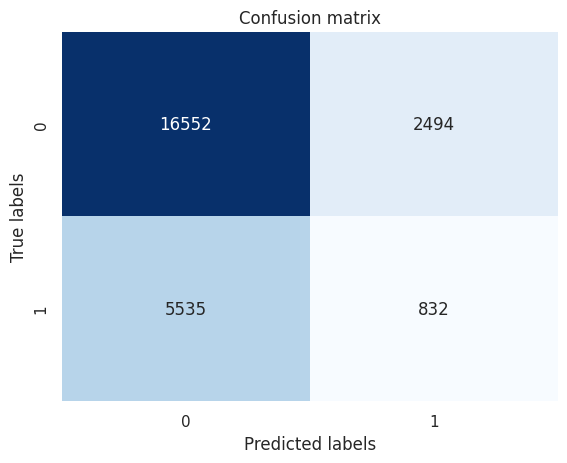

              precision    recall  f1-score   support

           0       0.75      0.87      0.80     19046
           1       0.25      0.13      0.17      6367

    accuracy                           0.68     25413
   macro avg       0.50      0.50      0.49     25413
weighted avg       0.62      0.68      0.65     25413



In [ ]:
plot_history(history5,model5)

In [ ]:
def create_model():
  model5 = Sequential()
  model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Conv1D(128, 5, activation='relu'))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Bidirectional(LSTM(64, return_sequences=True)))
  model5.add(BatchNormalization())
  model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Flatten())
  model5.add(Dense(1, activation='sigmoid'))
  model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model5

model5 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model5, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
2499/2499 [==============================] - 58s 21ms/step - loss: 0.6346 - accuracy: 0.7480
Epoch 2/10
2499/2499 [==============================] - 50s 20ms/step - loss: 0.5453 - accuracy: 0.7499
Epoch 3/10
2499/2499 [==============================] - 51s 20ms/step - loss: 0.5309 - accuracy: 0.7559
Epoch 4/10
2499/2499 [==============================] - 51s 20ms/step - loss: 0.5164 - accuracy: 0.7635
Epoch 5/10
2499/2499 [==============================] - 50s 20ms/step - loss: 0.5010 - accuracy: 0.7725
Epoch 6/10
2499/2499 [==============================] - 51s 21ms/step - loss: 0.4873 - accuracy: 0.7816
Epoch 7/10
2499/2499 [==============================] - 50s 20ms/step - loss: 0.4783 - accuracy: 0.7865
Epoch 8/10
2499/2499 [==============================] - 51s 21ms/step - loss: 0.4707 - accuracy: 0.7905
Epoch 9/10
2499/2499 [==============================] - 49s 20ms/step - loss: 0.4614 - accuracy: 0.7977
Epoch 10/10
625/625 [==============================] - 5s 8ms/st

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.79 (+/- 0.03)
Cross-Validation Precision: 0.63 (+/- 0.12)
Cross-Validation Loss: 0.47 (+/- 0.04)
Cross-Validation Recall: 0.44 (+/- 0.18)
Cross-Validation F1 Score: 0.51 (+/- 0.10)


## **L2 CNN-DistilBERT**

In [ ]:
# build the model
model6 = Sequential()
model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Flatten())
model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(1, activation='sigmoid'))

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
3124/3124 [==============================] - 19s 5ms/step - loss: 0.6113 - accuracy: 0.7478
Epoch 2/10
3124/3124 [==============================] - 20s 6ms/step - loss: 0.5523 - accuracy: 0.7481
Epoch 3/10
3124/3124 [==============================] - 20s 7ms/step - loss: 0.5428 - accuracy: 0.7481
Epoch 4/10
3124/3124 [==============================] - 16s 5ms/step - loss: 0.5357 - accuracy: 0.7481
Epoch 5/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.5254 - accuracy: 0.7481
Epoch 6/10
3124/3124 [==============================] - 17s 6ms/step - loss: 0.5173 - accuracy: 0.7481
Epoch 7/10
3124/3124 [==============================] - 17s 6ms/step - loss: 0.5096 - accuracy: 0.7481
Epoch 8/10
3124/3124 [==============================] - 17s 5ms/step - loss: 0.5036 - accuracy: 0.7515
Epoch 9/10
3124/3124 [==============================] - 17s 6ms/step - loss: 0.4983 - accuracy: 0.7608
Epoch 10/10
3124/3124 [==============================] - 17s 5ms/step - l

In [ ]:
test_loss, test_acc = model6.evaluate(test_embeddings, test_labels)

y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 2s 2ms/step
Test Accuracy: 0.7252980470657349
Test F1 Score: 0.12573575453976207
Test Recall: 0.07884403957907964
Precision: 0.31025957972805934


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model6.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 152, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 29, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_26 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 5, 128)         

795/795 [==============================] - 2s 3ms/step
[[17930  1116]
 [ 5865   502]]


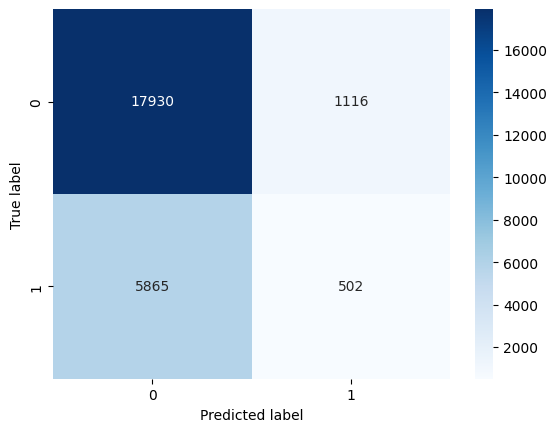

In [ ]:
y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

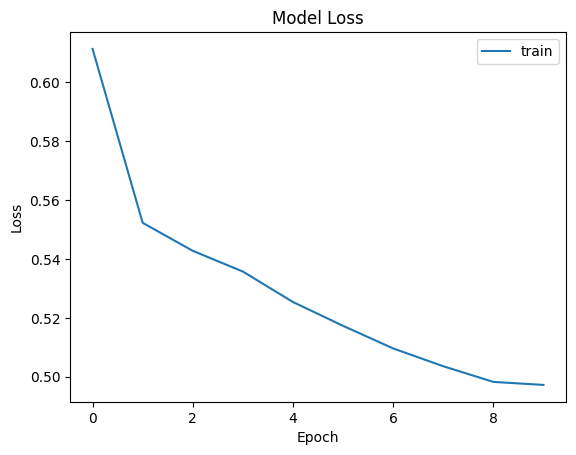

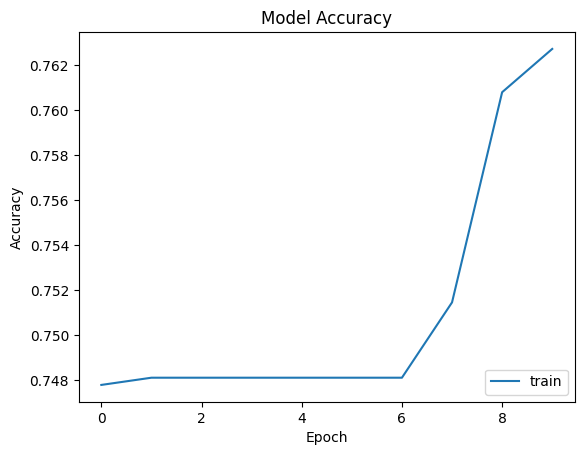

795/795 [==============================] - 2s 2ms/step


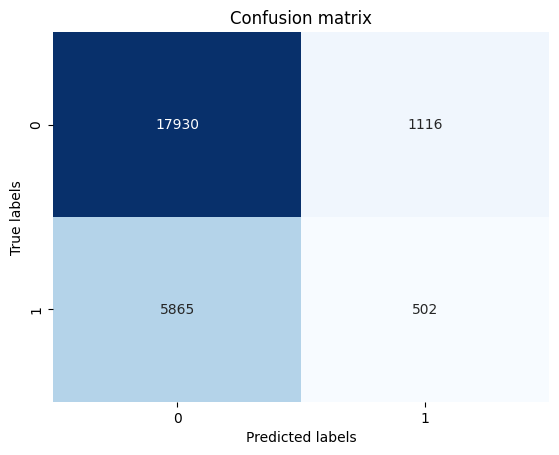

              precision    recall  f1-score   support

           0       0.75      0.94      0.84     19046
           1       0.31      0.08      0.13      6367

    accuracy                           0.73     25413
   macro avg       0.53      0.51      0.48     25413
weighted avg       0.64      0.73      0.66     25413



In [ ]:
plot_history(history6,model6)

In [ ]:
def create_model():
  model6 = Sequential()
  model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Flatten())
  model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(1, activation='sigmoid'))
  model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model6

model6 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model6, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
2499/2499 [==============================] - 17s 6ms/step - loss: 0.6214 - accuracy: 0.7478
Epoch 2/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.5550 - accuracy: 0.7481
Epoch 3/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.5464 - accuracy: 0.7481
Epoch 4/10
2499/2499 [==============================] - 16s 6ms/step - loss: 0.5372 - accuracy: 0.7481
Epoch 5/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.5291 - accuracy: 0.7481
Epoch 6/10
2499/2499 [==============================] - 14s 6ms/step - loss: 0.5204 - accuracy: 0.7481
Epoch 7/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.5117 - accuracy: 0.7481
Epoch 8/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.5055 - accuracy: 0.7525
Epoch 9/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.4989 - accuracy: 0.7664
Epoch 10/10
625/625 [==============================] - 2s 3ms/step
Epoch 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


625/625 [==============================] - 1s 2ms/step


In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.76 (+/- 0.02)
Cross-Validation Precision: 0.46 (+/- 0.46)
Cross-Validation Loss: 0.49 (+/- 0.02)
Cross-Validation Recall: 0.29 (+/- 0.32)
Cross-Validation F1 Score: 0.34 (+/- 0.36)


# **Text-Title-DistilBERT**

In [ ]:
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_title_distilbert_bin.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_title_distilbert_bin.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_title_distilbert_bin.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_title_distilbert_bin.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
train_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_distilbert_bin.npy')
train_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_distilbert_bin.npy')
test_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_distilbert_bin.npy')
test_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_distilbert_bin.npy')

In [ ]:
train_embeddings1 = tf.expand_dims(train_embeddings1, axis=-1)
test_embeddings1 = tf.expand_dims(test_embeddings1, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
title_input = Input(shape=(768,), name='title_bert')
text_input = Input(shape=(768,), name='text_bert')
shared_dense = Dense(768, activation='relu')
title_output = shared_dense(title_input)
text_output = shared_dense(text_input)
concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
dropped_out = Dropout(0.5)(concatenated)
output = Dense(1, activation='sigmoid', name='output')(dropped_out)
model = Model(inputs=[title_input, text_input], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=[tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)],
          y=train_labels,
          epochs=9,
          batch_size=16)

Epoch 1/9
3124/3124 [==============================] - 13s 4ms/step - loss: 0.5563 - accuracy: 0.7468
Epoch 2/9
3124/3124 [==============================] - 13s 4ms/step - loss: 0.5445 - accuracy: 0.7507
Epoch 3/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5370 - accuracy: 0.7521
Epoch 4/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5310 - accuracy: 0.7554
Epoch 5/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5237 - accuracy: 0.7566
Epoch 6/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5181 - accuracy: 0.7584
Epoch 7/9
3124/3124 [==============================] - 11s 4ms/step - loss: 0.5149 - accuracy: 0.7602
Epoch 8/9
3124/3124 [==============================] - 13s 4ms/step - loss: 0.5075 - accuracy: 0.7635
Epoch 9/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5032 - accuracy: 0.7664


In [ ]:
test_loss, test_acc = model.evaluate([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)], test_labels, verbose=2)

y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 2s - loss: 0.6019 - accuracy: 0.7248 - 2s/epoch - 3ms/step
795/795 [==============================] - 2s 2ms/step
Test Accuracy: 0.7248258590698242
Test F1 Score: 0.07463279078999603
Test Recall: 0.04429087482330768
Precision: 0.23697478991596638


In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_bert (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 text_bert (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 dense_138 (Dense)              (None, 768)          590592      ['title_bert[0][0]',             
                                                                  'text_bert[0][0]']              
                                                                                                  
 concatenated (Concatenate)     (None, 1536)         0           ['dense_138[0][0]',        

795/795 [==============================] - 1s 2ms/step
[[18138   908]
 [ 6085   282]]


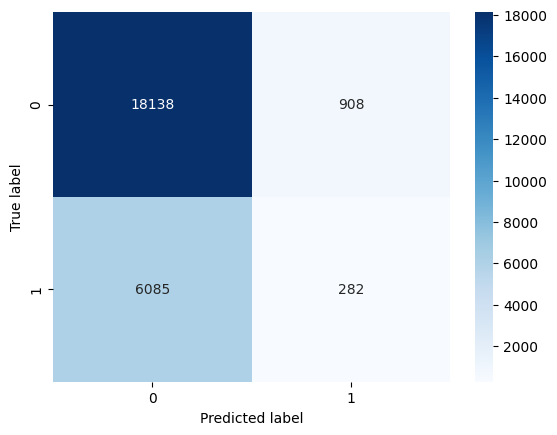

In [ ]:
y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def accuracy(y_true, y_pred):
    predictions = K.round(y_pred)
    correct_predictions = K.cast(K.equal(y_true, predictions), dtype='float32')
    accuracy_value = K.mean(correct_predictions)
    return accuracy_value

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_value = 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))
    return f1_value

def neg_log_loss(y_true, y_pred):
    loss = K.binary_crossentropy(y_true, y_pred)
    return -loss

def create_model():
    title_input = Input(shape=(768,), name='title_bert')
    text_input = Input(shape=(768,), name='text_bert')
    shared_dense = Dense(768, activation='relu')
    title_output = shared_dense(title_input)
    text_output = shared_dense(text_input)
    concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
    dropped_out = Dropout(0.5)(concatenated)
    output = Dense(1, activation='sigmoid', name='output')(dropped_out)
    model = Model(inputs=[title_input, text_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[accuracy, precision, recall, f1_score, neg_log_loss])
    return model

scoring = ['accuracy', 'precision', 'recall', 'f1_score', 'neg_log_loss']

# Prepare the input data
X = [tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)]
y = train_labels

# Initialize a list to store the evaluation metrics for each fold
results = []

kfold = StratifiedKFold(n_splits=5, shuffle=True)
for train_indices, val_indices in kfold.split(X[0], y):
    # Convert indices to TensorFlow tensors
    train_indices = tf.constant(train_indices)
    val_indices = tf.constant(val_indices)

    # Split the data into training and validation sets for the current fold
    X_train = [tf.gather(X[0], train_indices), tf.gather(X[1], train_indices)]
    X_val = [tf.gather(X[0], val_indices), tf.gather(X[1], val_indices)]
    y_train = tf.gather(y, train_indices)
    y_val = tf.gather(y, val_indices)

    # Create the model
    model = create_model()

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

    # Evaluate the model on validation data
    fold_results = {}
    eval_results = model.evaluate(X_val, y_val, verbose=0)
    for metric, score in zip(model.metrics_names, eval_results):
        if metric == 'neg_log_loss':
            fold_results[metric] = -score
        else:
            fold_results[metric] = score
    results.append(fold_results)

# Calculate the mean and standard deviation of the evaluation metrics
mean_results = {metric: np.mean([fold[metric] for fold in results]) for metric in scoring}
std_results = {metric: np.std([fold[metric] for fold in results]) for metric in scoring}

# Print the results
for metric in scoring:
    print('=========================================')
    print(metric, "Mean:", mean_results[metric])
    print(metric, "Std:", std_results[metric])
    print('=========================================')


accuracy Mean: 0.7695356369018554
accuracy Std: 0.003923700309752815
precision Mean: 0.5780967891216278
precision Std: 0.04589498195039255
recall Mean: 0.16408706605434417
recall Std: 0.050276463913412145
f1_score Mean: 0.2406742751598358
f1_score Std: 0.061330118483636155
neg_log_loss Mean: 0.49585249423980715
neg_log_loss Std: 0.005735452576479757


# **Max Worth-Title-DistilBERT**

In [ ]:
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_title_distilbert_bin.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_title_distilbert_bin.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_title_distilbert_bin.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_title_distilbert_bin.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
train_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_max_bin.npy')
train_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_max_bin.npy')
test_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_max_bin.npy')
test_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_max_bin.npy')

In [ ]:
train_embeddings1 = tf.expand_dims(train_embeddings1, axis=-1)
test_embeddings1 = tf.expand_dims(test_embeddings1, axis=-1)

In [ ]:
train_embeddings1.shape

TensorShape([49972, 768, 1])

In [ ]:
title_input = Input(shape=(768,), name='title_bert')
text_input = Input(shape=(768,), name='text_bert')
shared_dense = Dense(768, activation='relu')
title_output = shared_dense(title_input)
text_output = shared_dense(text_input)
concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
dropped_out = Dropout(0.5)(concatenated)
output = Dense(1, activation='sigmoid', name='output')(dropped_out)
model = Model(inputs=[title_input, text_input], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=[tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)],
          y=train_labels,
          epochs=9,
          batch_size=16)

Epoch 1/9
3124/3124 [==============================] - 14s 4ms/step - loss: 0.5558 - accuracy: 0.7481
Epoch 2/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5409 - accuracy: 0.7519
Epoch 3/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5341 - accuracy: 0.7555
Epoch 4/9
3124/3124 [==============================] - 13s 4ms/step - loss: 0.5265 - accuracy: 0.7562
Epoch 5/9
3124/3124 [==============================] - 13s 4ms/step - loss: 0.5205 - accuracy: 0.7609
Epoch 6/9
3124/3124 [==============================] - 13s 4ms/step - loss: 0.5134 - accuracy: 0.7624
Epoch 7/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5079 - accuracy: 0.7663
Epoch 8/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5027 - accuracy: 0.7686
Epoch 9/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.4990 - accuracy: 0.7708


In [ ]:
test_loss, test_acc = model.evaluate([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)], test_labels, verbose=2)

y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype('int')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 2s - loss: 0.5923 - accuracy: 0.7359 - 2s/epoch - 3ms/step
795/795 [==============================] - 2s 2ms/step
Test Accuracy: 0.7359225749969482
Test F1 Score: 0.04632655961347165
Test Recall: 0.025600753887231036
Precision: 0.24328358208955222


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_bert (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 text_bert (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 dense_39 (Dense)               (None, 768)          590592      ['title_bert[0][0]',             
                                                                  'text_bert[0][0]']              
                                                                                                  
 concatenated (Concatenate)     (None, 1536)         0           ['dense_39[0][0]',         

795/795 [==============================] - 1s 2ms/step
[[18539   507]
 [ 6204   163]]


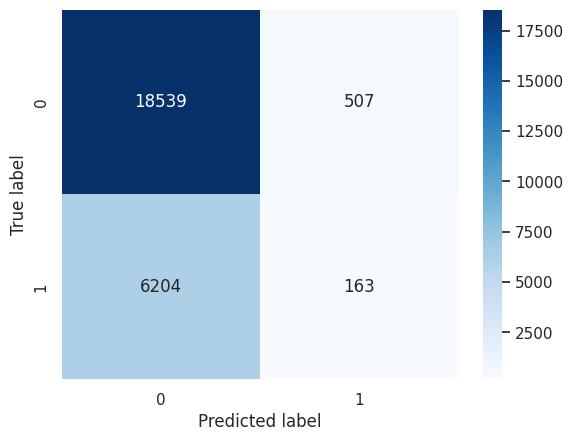

In [ ]:
y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def accuracy(y_true, y_pred):
    predictions = K.round(y_pred)
    correct_predictions = K.cast(K.equal(y_true, predictions), dtype='float32')
    accuracy_value = K.mean(correct_predictions)
    return accuracy_value

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_value = 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))
    return f1_value

def neg_log_loss(y_true, y_pred):
    loss = K.binary_crossentropy(y_true, y_pred)
    return -loss

def create_model():
    title_input = Input(shape=(768,), name='title_bert')
    text_input = Input(shape=(768,), name='text_bert')
    shared_dense = Dense(768, activation='relu')
    title_output = shared_dense(title_input)
    text_output = shared_dense(text_input)
    concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
    dropped_out = Dropout(0.5)(concatenated)
    output = Dense(1, activation='sigmoid', name='output')(dropped_out)
    model = Model(inputs=[title_input, text_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[accuracy, precision, recall, f1_score, neg_log_loss])
    return model

scoring = ['accuracy', 'precision', 'recall', 'f1_score', 'neg_log_loss']

# Prepare the input data
X = [tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)]
y = train_labels

# Initialize a list to store the evaluation metrics for each fold
results = []

kfold = StratifiedKFold(n_splits=5, shuffle=True)
for train_indices, val_indices in kfold.split(X[0], y):
    # Convert indices to TensorFlow tensors
    train_indices = tf.constant(train_indices)
    val_indices = tf.constant(val_indices)

    # Split the data into training and validation sets for the current fold
    X_train = [tf.gather(X[0], train_indices), tf.gather(X[1], train_indices)]
    X_val = [tf.gather(X[0], val_indices), tf.gather(X[1], val_indices)]
    y_train = tf.gather(y, train_indices)
    y_val = tf.gather(y, val_indices)

    # Create the model
    model = create_model()

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

    # Evaluate the model on validation data
    fold_results = {}
    eval_results = model.evaluate(X_val, y_val, verbose=0)
    for metric, score in zip(model.metrics_names, eval_results):
        if metric == 'neg_log_loss':
            fold_results[metric] = -score
        else:
            fold_results[metric] = score
    results.append(fold_results)

# Calculate the mean and standard deviation of the evaluation metrics
mean_results = {metric: np.mean([fold[metric] for fold in results]) for metric in scoring}
std_results = {metric: np.std([fold[metric] for fold in results]) for metric in scoring}

# Print the results
for metric in scoring:
    print('=========================================')
    print(metric, "Mean:", mean_results[metric])
    print(metric, "Std:", std_results[metric])
    print('=========================================')

accuracy Mean: 0.7735350489616394
accuracy Std: 0.006090365576594195
precision Mean: 0.5940842270851135
precision Std: 0.04795851407178523
recall Mean: 0.1751592442393303
recall Std: 0.055926906153087465
f1_score Mean: 0.25507041811943054
f1_score Std: 0.06711433131923994
neg_log_loss Mean: 0.49179226756095884
neg_log_loss Std: 0.005493585273313387
